# Cluster algorithms for Monte Carlo simulation of statistical models

## Abstract

Computational methods for approximating physical systems are becoming increasingly important within all branches of science. Scientific models do not necessarily need to be complex in order to make algebraic solutions difficult to find. This is especially true for statistical physics. Computational approaches open the possibility to investigate statistical mechanical models, by averaging many small calculations. The processing power available allows computers to perform more than a thousand calculations in rapid succession. This type of approach is known as the Monte Carlo method. The first and most common Monte Carlo method algorithm is the Metropolis-Hastings algorithm. Although a very successful algorithm, the Metropolis-Hastings algorithm requires long runtimes, especially around critical temperatures. With computational power limited, different algorithms were developed to overcome these difficulties. These new algorithms became known as cluster algorithms, named after the clusters formed with each pass of the algorithm. Significant performance improvements were seen, most notably around critical points. This report aims to investigate directly the differences between cluster algorithms and the Metropolis-Hastings algorithm on statistical mechanics models. Analysis is carried out in the context of the Ising model on a square lattice; other models are discussed, and algorithms are provided. The autocorrelation times of the different algorithms are compared, and properties such as the dynamic exponent are estimated. Potential improvements to the algorithms are presented at the end.

## Imports

In [63]:
'''Imports are listed here. Commented out ones are not required for this notebook to run but are used within one or more modules.'''

import matplotlib.pylab as plt
#import pandas as pd
import numpy as np
#import time

#from scipy.optimize import curve_fit
from scipy import stats
#from numpy.random import Generator, MT19937, SeedSequence
#from numpy.random import Generator, SFC64, SeedSequence
#from statsmodels.tsa.stattools import acf, pacf

rng = np.random.default_rng()

## 1 - Introduction

Monte Carlo methods utilise repeated random sampling to produce approximate values. By generating random inputs sampled using a predetermined probability distribution, deterministic calculations can be performed on the data set. Repeating for adequate time periods and averaging allows approximate solutions to be found for problems where algebraic manipulation cannot be used. First developed during the Second World War by Stanisław Ulam and John von Neumann, the method was a statistical approach to the problem of neutron diffusion in fissionable material [1]. Following the initial Monte Carlo method, the term has evolved into a class of methods; all of which encompass the idea of using randomness to simulate certainty.

Many models, specifically in statistical mechanics, have a simplistic objective. This usually involves finding the macrostate that minimises the thermodynamic free energy. Complexity is introduced to the problem through either interactions or the number of microstates. For classical systems, it is quickly unfeasible to analyse all possible arrangements of these microstates; here lies the power of the Monte Carlo method. Sampling from a given probability distribution and averaging the results dramatically reduces the required computational time. The reduction in runtime becomes a helpful quantifier for the performance of the algorithm for a given model. Performance, however, cannot be fully attributed to runtime. The nature of the Monte Carlo method leads to new problems, like critical slowing down, and hence accuracy around critical points should also be investigated.

This report starts by considering the statistical background of local Monte Carlo simulations. Being the first Monte Carlo method; the Metropolis-Hastings algorithm is discussed first. Topics like ergodicity, efficiency, critical slowing down, and autocorrelation follow before discussing specific statistical models. The theory for cluster algorithms completes the analysis section. Implementation of the Ising model algorithms follows the analysis. Autocorrelation is measured for the algorithms, and its dependence on the properties of the system is studied. Finally, a comparison of the algorithms is presented in the conclusion.

## 2 - Analysis

### 2.1 - Local Monte Carlo Simulations

Statistical mechanical models apply the framework of statistics to large collections of microstates. A core result is that systems can be described by their partition function,

$$Z = \sum_{\text{all states s}} exp(-\beta E_{s}),$$

where $E_{s}$ is the energy of the microstate $s_{i}$ and $\beta$ is the thermodynamic beta. These microstates exist in a configuration space. Binary systems, such as the Ising model, have a configuration space that scales as 2$^{N}$ and the partition function becomes a summation over a 2dN dimensional phase space in which N particles exist. For real systems, N can take values of the order 23. This makes the summation computationally expensive. One method is to treat the summation as an integral, though large computations are still required to achieve acceptable accuracy. Sampling methods can reduce the number of computations by calculating properties for chosen states and averaging. If the states are chosen at random, this is known as simple sampling. This method works for properties with smoothly varying functions, however, it introduces a large uncertainty due to the Boltzmann factor. A simple calculation is included as an appendix. To improve accuracy, a weighting can be added, thereby ensuring states that contribute to the summation more are better represented when calculating the average. The weighting forms a probability distribution from which the states are randomly chosen. The partition function requires the probability distribution to take the form $exp(-\beta E_{s})/Z$.

The probability distribution contains the partition function as a normalisation constant. This means that absolute probabilities cannot be calculated, due to Z being unknown. Expected values, however, can be found without knowledge of Z through the Metropolis-Hastings (MH) algorithm. The underlying process involves generating a Markov chain of states. Markov chains are sequences in which each member only depends on the member directly preceding it. To create these chains an initial state, $s_{i}$, is chosen, ensuring that its Boltzmann factor, $\pi_{i}$, is non-vanishing. The next member, trial state $s_{j}$, is created from $s_{i}$ and is either accepted or rejected. Accepting $s_{j}$ adds the state into the Markov chain while rejecting adds $s_{i}$. Acceptance of the trial state is determined through direct comparison with the last member of the Markov chain. Each step has an associated transition probability, forming a transition matrix $P_{ij}$. The satisfied condition can be represented as the matrix equation

$$\pi_{i}P_{ij} = \pi_{j}.$$

Significant simplification can be achieved through noting that statistical models usually respect time reversal symmetry. This means that the average number of transitions from i to j is balanced by the transitions from j to i. Reversibility imposes an additional condition on the transition matrix, called detailed balance.

$$\pi_{i}P_{ij} = \pi_{j}P_{ji}$$

The matrix elements $P_{ij}$ can be decomposed into an a priori probability $P^{priori}_{ij}$ and an acceptance probability $P^{acc}_{ij}$. Where $P^{priori}_{ij}$ gives the probability of generating $s_{j}$ from $s_{i}$ and $P^{acc}_{ij}$ is the probability of accepting the trial state. Taking $P^{priori}_{ij}$ to be symmetric, the detailed balance condition depends only on the acceptance probabilities. This can be rewritten explicitly as the ratio of the acceptance probabilities.

$$\frac{P^{acc}_{ij}}{P^{acc}_{ji}} = exp{(-\beta(E_{j}-E_{i}))}$$

The problem has been reduced to finding a solution for the ratio. However, there exists a set of solutions for the acceptance probability. To uniquely define the acceptance probability, the original MH algorithm proposes the solution,

$$P_{ij} = min[exp(-\beta\Delta_{ij}), 1]$$

with $\Delta_{ij} = E_{j} - E_{i}$. Thus, trial states are immediately accepted if their energy is lower than their parent state. Higher energy trial states are accepted with the probability equal to the ratio of the Boltzmann factors. With the generation of the Markov chain, expectation values can be found by averaging the values, $A_{n}$, for each state.

$$\langle A \rangle = \frac{1}{Z} \sum A_{s} exp(-\beta E_{s}) \approx \frac{1}{M} \sum_{n=1}^{M} A_{n}$$

### Ergodicity

The algorithm was simplified by ensuring that the detailed balance condition is satisfied. However, this is not the only condition required for the algorithm to work. It is assumed that the total probability sums to unitary; this corresponds to including all possible states in the average. All states must be accessible; this is known as ergodicity. There should exist a path from each state in phase space to every other state, via a series of trial moves. If this is not the case, the approximated expectation value will differ considerably from the actual value. For the MH algorithm, ergodicity is guaranteed by assuming detailed balance and the Perron-Frobenius theorem. Proof of this can be found in [2]. Ergodicity is important for the convergence of Markov chains. This is summarised by the Ergodic theorem: for a dynamic system that is ergodic, the time average of a property over the system's trajectory is equal to the average of that property over the entire phase space.

### Efficiency and Critical slowing down

The variance of the approximated expectation value is minimised by increasing the number of independent samples in the Markov chain. It is desirable to maximise the production rate of such samples. New samples are independent only if they are sufficiently decorrelated from the current sample. Decorrelation is related to the size of the modification between samples. Therefore, larger modifications can be used to produce more independent samples. This is problematic because of the large energy difference associated with large modifications. Large energy differences, $\Delta_{ij}$, result in low acceptance probabilities. These two effects are inversely proportional; the balance between them gives the efficiency of the algorithm. For example, a sample can contain multiple particles, and the modification between samples can be displacing one such particle. The magnitude of the maximum displacement, $l$, would characterise the acceptance probability and the modification size, and hence the algorithm efficiency.

Balancing these effects to maximise the generation of independent samples can generally be achieved with a high success rate. However, the field of critical phenomena suggests that for systems that exhibit a continuous phase transition challenges arise around this critical point. This is the case for the Ising Model. Around the critical point, thermodynamic properties depend on the correlation length, $\xi$, via a power law. $\xi$ diverges according to a power law of the difference between the temperature and critical temperature. This is summarised below.

$$\psi \propto \xi^{z} \propto |T - T_{c}|^{-z \alpha}$$

Here, z represents the dynamical exponent and $\alpha$ is a positive number. Monte Carlo simulations must be implemented on finite-sized systems. This introduces a characteristic length, $L$, that the correlation size cannot exceed. Divergence of $\xi$ is limited to a maximum value denoted $\xi_{max}$. This means that the power law takes on a different form when temperatures are sufficiently close to the critical temperature.

$$\psi \propto (\xi_{max})^{z} = L^{z}$$

This relationship is interpreted as critical slowing down. Increasing the size of the system will result in longer correlation times - the difficulty of producing independent samples scales with the system size.

### Landau theory

Landau theory provides a way to calculate/estimate $\alpha$, known as the critical exponent. Expanding the free energy of the system around a critical point (phase transition) and minimising, allows for citical exponents to emerge. Four critical exponents exist: $\alpha$, $\beta$, $\gamma$, and $\delta$. Using renormalisation group theory, the exponents are shown to obey:

$$\alpha = 2 - \nu D$$
$$\beta = \frac{1}{2} \nu(D-2+\eta)$$
$$\delta = \frac{D+2-\eta}{D-2+\eta}$$
$$\gamma = \nu(2-\nu)$$

Fixing the dimensionality, D, and knowledge of $\nu$ and $\eta$ is sufficient to define all critical exponents. $\nu$ represents how fast one leaves the fixed point in renormalisation group theory. $\eta$ is related to the scaling behaviour of energy-energy correlations.

For the case of the 2D Ising model: $\nu = 1$ and $\eta = \frac{1}{4}$. This predicts spontaneous symmetry breaking in the spin at a critical point (phase transition). This is seen as a preferred direction, hence magnetisation in the system.

### Autocorrelation

The previous section showed that correlation length can be used to define the efficiency of an algorithm. Therefore, it is important to quantify the degree of correlation and its evolution over time. This is achieved through the autocorrelation function; $R_{XX}(t_{1},t_{2})$. For ease of comparison, the auto-covariance function can be defined by subtracting the mean value, $\mu$, of the observable, $X$.

$$K_{XX}(t_{1},t_{2}) = R_{XX}(t_{1},t_{2}) - \mu_{t_{1}}\mu_{t_{1}}$$

In this definition, the complex conjugation has been dropped as the values are derived from observables. Observables cannot have complex values. Defining an autocorrelation time requires the assumption that the magnitude of $K_{XX}(t_{1},t_{2})$ falls exponentially. This causes a characteristic time scale to emerge.

$$K_{XX}(t_{1},t_{2}) \approx e^{-t/\tau}$$

The auto-covariance may not follow this dependence exactly. However, providing there exists a dominant frequency, the assumption is adequate for the analysis. $\tau$ can be measured from the auto-covariance data by recording the first drop below $1/e$. $K_{XX}(t_{1},t_{2})$ has a strong dependence on the observable $X$. This can be seen explicitly in the following equation.

$$K_{XX}(t_{1},t_{2}) = \langle X_{t_{1}} X_{t_{2}} \rangle - \langle X_{t_{1}} \rangle \langle X_{t_{2}} \rangle$$

Observable dependence in the autocorrelation function follows into the correlation length; hence uniquely defines the power law exponent, $\alpha$. $\alpha$ is observable dependent and should remain constant across multiple algorithms. In contrast, the dynamical exponent $z$ changes according to the algorithm used. Efficient algorithms have values closer to zero corresponding to shorter autocorrelation times near critical points.

It should be noted that the assumption of exponential decay is not valid at critical points, this is due to the scaling laws. Physical properties obey a power law divergence rather than exponential decay. This means autocorrelation should be treated with caution around these points.

### 2.2 - Ising Model

Of all the statistical models, the Ising model is the most useful for analysing Monte Carlo methods. Using a classical approach, the Ising model describes ferromagnetism via simplified spin-spin interactions. The configuration space is defined as a $d$-dimensional lattice of size $L$. Each lattice site is assigned a spin, usually taking a fixed magnitude scalar value. It is conventional to assume periodic boundary conditions. Working on a square lattice, $d=2$, the Hamiltonian and partition function can be defined.

$$E = -J\sum_{i}\sum_{j}s_{i}s_{j} - \mu H\sum_{i=1}^{N}s_{i}$$

$$Z = \sum_{s\in\{-1,1\}^{N}} e^{-\beta E}$$

where summation is carried out over all spins $s_{i}$ and their neighbours $s_{j}$ with exchange energy $J$, magnetic moment $\mu$ and externally applied magnetic field $H$. $N = L^{2}$ are is the size of square lattice and $\beta = \frac{1}{kT}$. Key properties of the system can be found such as; the expected total magnetisation $\langle M \rangle$, the magnetic susceptibility $\chi$, and heat capacity $C$. These are all defined below.

$$\langle M \rangle = \sum_{s\in\{-1,1\}^{N}} M(s) \frac{e^{-\beta E}}{Z}$$

$$\chi = \frac{1}{N}\frac{\partial M}{\partial H} \approx \langle M^{2} \rangle - \langle M \rangle^{2}$$

$$C = \frac{\sigma_{E}^{2}}{kT^{2}}$$

with $\sigma_{E}$ being the standard deviation of the system energy.

### Onsager's solution

An analytical solution for the complete 2D Ising model has been challenging to obtain. Though in some limiting simplified cases such solutions have been found. Onsager, in 1944, published the solution to the Ising model on a 2D square lattice with periodic boundary conditions and infinite size while in no external magnetic field. The result allowed the expected value for the magnetisation to written as:

$$\langle M\rangle= \begin{cases}0 & \text { if } T \geq T_c \\ \pm \left(1-\sinh \left(2 \beta J\right)^{-4}\right)^{\frac{1}{8}} & \text { if } T<T_c\end{cases}$$

where the critical temperature, $T_c$, satisfies the relation

$$T_c=\frac{2 J}{k_b \ln (1+\sqrt{2})}$$

The critical temperature defines the point at which fluctuations in the lattice become increasingly large, corresponding to a phase transition. Figure 1 shows this transition for $J=1$, while Figure 2 shows the $J$ dependence of the critical point.

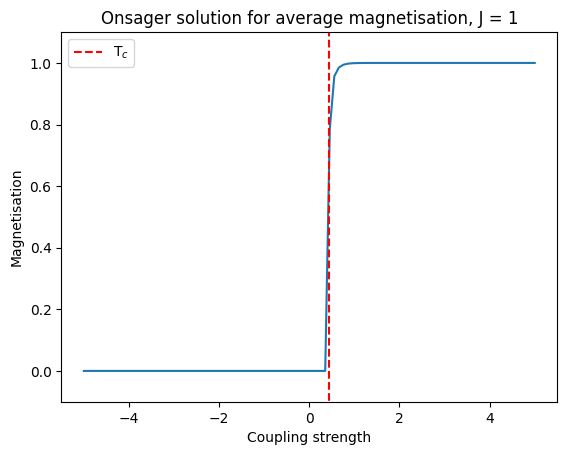

In [64]:
'''Set up range for plot'''
betaJs_analytical = np.linspace(-5,5,100)

'''Defines the magnetisation and returns values'''
M_sol = []

def M_analytical_coupling(betaJs_analytical,M_sol,T_c = np.log(1 + np.sqrt(2)) / 2):
    for val in betaJs_analytical:
        if val < T_c:
            M_sol.append(0)
        else:
            M_sol.append((1 - np.sinh(2 * val)**(-4))**(1/8))
    return M_sol

'''Plots graph'''
plt.plot(betaJs_analytical,M_analytical_coupling(betaJs_analytical,M_sol))
plt.vlines(np.log(1+np.sqrt(2))/2,ymin=-0.5,ymax=1.5,colors='r',linestyle='--',label=r'T$_{c}$')
plt.ylim(-0.1,1.1)
plt.legend()
plt.title('Onsager solution for average magnetisation, J = 1')
plt.xlabel('Coupling strength')
plt.ylabel('Magnetisation')
plt.show()

Magnetisation of 2D Ising Model around critical point. Plotted against coupling strength which for $J=1$ is equivalent to inverse temperature. The critical temperature is identified by the dashed red line.

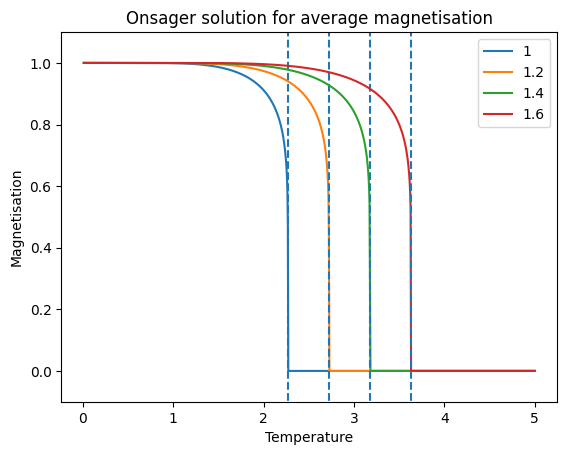

In [65]:
'''Set up range for plot'''
Js = [1,1.2,1.4,1.6]
Ts_analytic = np.linspace(0.01,5,1000)

'''Defines the magnetisation and returns values'''
M_sol = []

def M_analytical_temp(Ts_analytical,M_sol,J):
    T_c = 2*J/np.log(1 + np.sqrt(2))
    
    for val in Ts_analytical:
        if val > T_c:
            M_sol.append(0)
        else:
            M_sol.append((1 - np.sinh(2 * J/val)**(-4))**(1/8))
    return M_sol

'''Plots graph'''
for i in Js:
    plt.plot(Ts_analytic,M_analytical_temp(Ts_analytic,M_sol,i),label=i)
    plt.vlines(2*i/np.log(1+np.sqrt(2)),ymin=-0.5,ymax=1.5,linestyle='--')
    M_sol = []
plt.ylim(-0.1,1.1)
plt.title('Onsager solution for average magnetisation')
plt.xlabel('Temperature')
plt.ylabel('Magnetisation')
plt.legend()
plt.show()

Onsager solution for varying coupling constant, from 1 to 1.6. Increasing coupling causes the critical temperature to move to the right.

### 2.3 - Other Statistical Models

Other statistical models can be investigated using Monte Carlo methods other than the Ising model. Interpretating the Ising model as a discrete system; the natural progression is hard disks. In 2D, this involves setting a configuration space in which circles live. The circles are free to inhabit any position; providing they do not overlap. Hard disks are the continuous extension of the Ising model. Models involving hard disks have been used in areas such as looking at interference in nonlinear dynamical models [3].<br>

Looking back at the Ising model, multiple modifications have been suggested to the original model. One modification is to allow the spins to take any arbitrary angle, but retaining the fixed magnitude - this is the XY model. The Potts model extends the Ising model by increasing the number of values the spin can have. Interactions beyond the nearest neighbour may be considered. For some crystal systems, next-nearest neighbours contribute significantly, and the original Ising model does not consider these. Spin glass (Edwards-Anderson model) combines a lot of these with the additional modification that the coupling to spin pair dependent. The distribution of interactions are taken to be a Gaussian distribution.<br>

Away from the Ising model, the Metropolis-Hastings algorithm has been adapted to approximate global maximisation in a large search space. This is known as simulated annealing. Due to time constraints, the report is restricted to looking at the original Ising model. However, for interest, pseudocode for simulated annealing [4] is included below along with discussion into its learning complexity [5].

### Pseudocode

Initialise parameters;<br>
S=generate initial solution();<br>
T = T0;<br>
While(T < Tf)<br>
- Until(N <= I-Iter)<br>
    - Generate solution S' in the neighbourhood of S<br>
        - if f(S') < f(S)<br>
            - S <- S'<br>
        - else<br>
            - diff = f(S') - f(S)<br>
            - r = random();<br>
            - if r < exp(-diff/k*T)<br>
            - S <- S'<br>
        - T = aXT;<br>
Return best solution found;

### 2.5 - Cluster Algorithms

So far, the only algorithm looked at is the MH algorithm. This is a local algorithm. Local algorithms involve analysing a single random state per iteration. It can, therefore, take a very long time for all states to be explored. With the aim of reducing the run time of the code, cluster algorithms were developed. Cluster algorithms adapt the original MH algorithm to reduce the run time. This is achieved by grouping states together, or clustering. Cluster algorithms are particularly useful for hard disk simulations as local moves are incredibly inefficient. Particle overlap is common, and hence local moves are usually rejected.

The focus of this report is the Ising model with periodic boundary conditions, and there are two main cluster algorithms for the Ising model. These are the Swendsen-Wang (SW) algorithm and the Wolff (W) algorithm [6,7]. Starting with the SW algorithm, the outline of the general technique is as follows.

1. Each pair of spin nearest neighbours that are aligned is assigned a bond with a probability $p = 1 - exp(-2\beta J)$. Where J is the coupling constant.
2. All spins that are connected via a bond form a single cluster. This subdivides the system into multiple clusters of like spins.
3. Clusters have their spin flipped with a probability of $\frac{1}{2}$.
4. Existing bonds are removed, and the new arrangement forms the next member of the Markov chain.

The SW algorithm divides the system into multiple clusters of like spins. Algorithms of this kind are known as global cluster algorithms. On the other hand, the W algorithm forms a single cluster within the system. The general technique is:

1. A spin state i is selected at random.
2. Nearest neighbours are considered. Providing their spins are parallel (like spins) and not already contained within the cluster, the neighbour is added to the cluster with probability $p = 1 - exp(-2\beta J)$.
3. Each neighbour added to the cluster is added into the 'stack'. A random spin from the stack is chosen and step 2. is repeated for this spin state.
4. Repeat steps 2. and 3. until the stack is empty.
5. The cluster has been formed and all spins in the cluster are flipped.

For completeness, some cluster algorithms for hard disk simulation will be discussed in the following. However, due to time constraints, these algorithms will not be implemented in this report. The first algorithm was proposed by Dress and Krauth in 1995 [8]. This algorithm works by rotating the entire system with respect to a randomly generated pivot point. The rotated system is superimposed onto the original. Clusters of overlapping disks are isolated and flipped independently. Flipping involves exchanging clusters between the rotated and original systems. Multiple clusters form within each iteration; hence, the algorithm is global. An alternative single cluster algorithm has also been designed. The iteration is succinctly described in [9] and is included below.

1. In a given configuration C, a “pivot” is chosen at random.
2. A particle i is selected as the first particle that belongs to the cluster. This particle is moved via a point reflection with respect to the pivot. In its new position, the particle is referred to as i'.
3. The point reflection in step 2 is repeated iteratively for each particle j that overlaps with i'. Thus, if the (moved) particle j' overlaps with another particle k, particle k is moved as well. Note that all translations involve the same pivot.
4. Once all overlaps have been resolved, the cluster move is complete.

The hard disk algorithms described above are known as generalised geometric cluster algorithms (GCAs). They have since been expanded to include particle interaction through a 'soft potential'.

## 3 - Implementation and Results

### 3.1 - Setup

The program has been split up into multiple files to reduce complexity. These are imported as modules where they are required.

In [66]:
'''Importing necessary modules. These are neither standard nor third-party imports.'''
import setup
import MH
import SW
import Wolff

### 3.2 - Metropolis-Hastings Algorithm

The MH algorithm is described in Section 2.1 and the relevant functions are contained within the MH.py module. During the implementation of the algorithm, black tiles represent spin up (1) and white tiles represent spin down (-1). Firstly, the accuracy of the script was tested for varying $\beta$J values, imaged at set time intervals. $\beta$J represents the degree of coupling between spin sites. Larger values (strong coupling) should produce a lattice for large domains (clusters of spin). MH_Gather_plot_data.py was used to produce the plots.

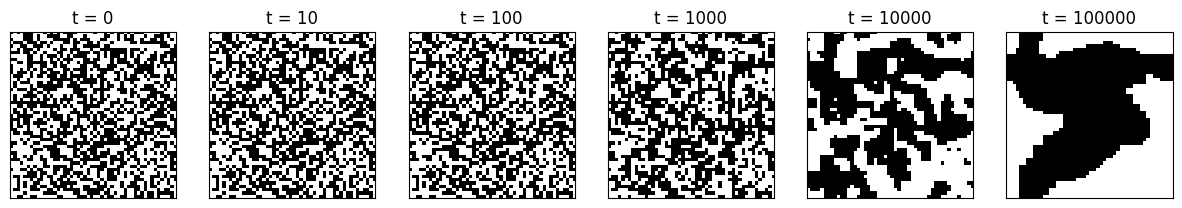

In [67]:
'''L = 50, betaJ = 1.5, betaMuH = 0'''
plot_times = [0,10,100,1000,10000,100000]
fig, ax = plt.subplots(1,len(plot_times),figsize=(15,5))

for i in plot_times:
    plot = np.load(f"Data/MH_test_50_1.5_0/plot_{i}.npy", allow_pickle=True)
    setup.plot_lattice(plot,ax[plot_times.index(i)],"t = {}".format(i))
    
plt.show()

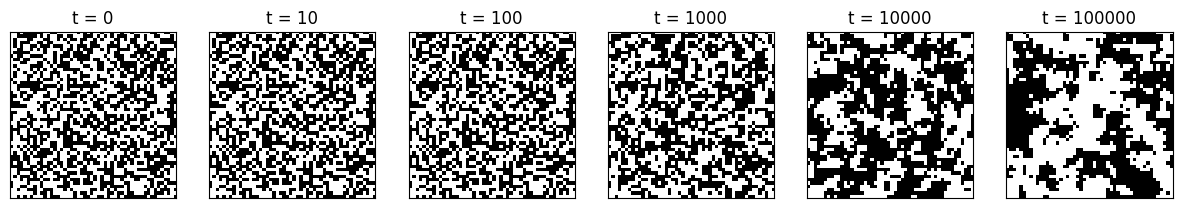

In [68]:
'''L = 50, betaJ = 0.4, betaMuH = 0'''
fig, ax = plt.subplots(1,len(plot_times),figsize=(15,5))

for i in plot_times:
    plot = np.load(f"Data/MH_test_50_0.4_0/plot_{i}.npy", allow_pickle=True)
    setup.plot_lattice(plot,ax[plot_times.index(i)],"t = {}".format(i))
    
plt.show()

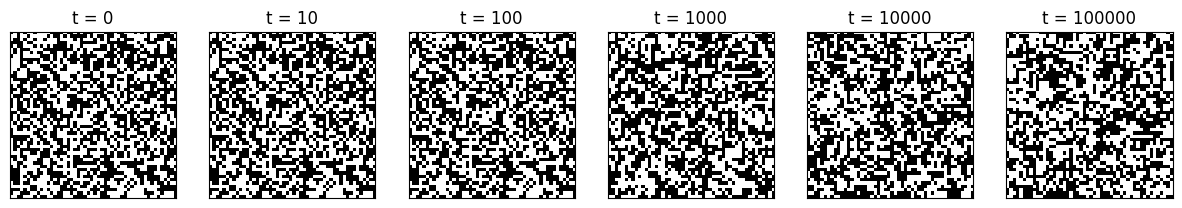

In [69]:
'''L = 50, betaJ = 0.1, betaMuH = 0'''
fig, ax = plt.subplots(1,len(plot_times),figsize=(15,5))

for i in plot_times:
    plot = np.load(f"Data/MH_test_50_0.1_0/plot_{i}.npy", allow_pickle=True)
    setup.plot_lattice(plot,ax[plot_times.index(i)],"t = {}".format(i))
    
plt.show()

The evolution of the lattice is shown for $\beta$J values of 1.5, 0.4, and 0.1 - in this order. Each evolution begins with a randomly distributed arrangement of spins, and the final lattice is consistent with the expected distribution for that coupling value.<br>

The evolution of the lattice reveals that it takes multiple iterations to reach the 'final' distribution. In Monte Carlo simulations the 'final' distribution is the stationary distribution. When calculating the physical quantities of the system, it is assumed that the system already has a stationary distribution. Therefore, the system must be allowed to equilibrate before taking measurements. The equilibration can be demonstrated by looking at the absolute magnetisation of the lattice. Graphs of the evolution of the absolute magnetisation are shown below for different coupling values. Equilibration data was gathered using MH_Gather_M_data.py.

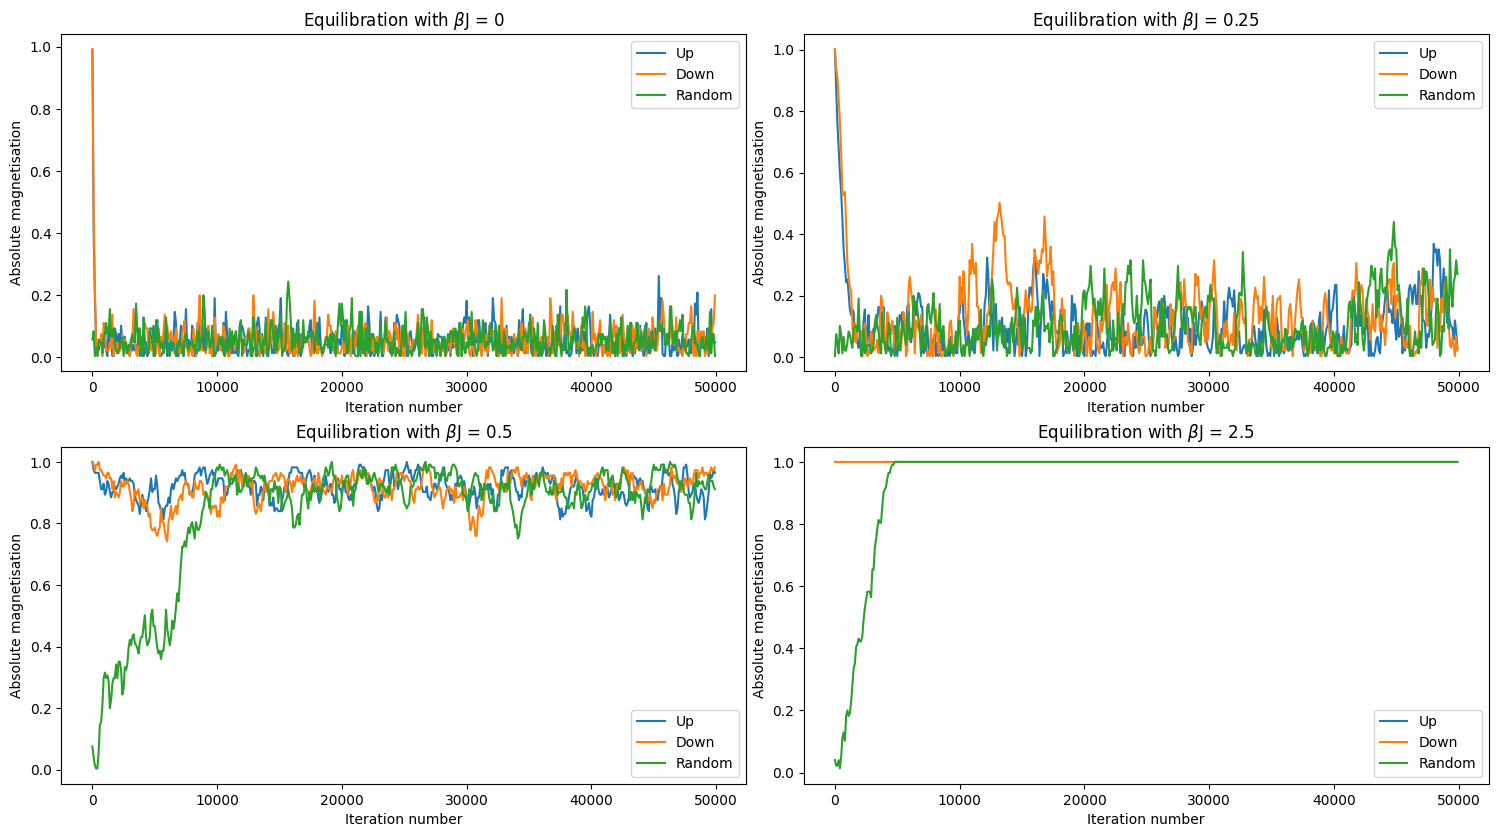

In [70]:
avg_times = np.arange(1,50000,100)

fig, ax = plt.subplots(2,2,figsize=(15,5))
fig.tight_layout()
plt.subplots_adjust(left=None, bottom=0.001, right=None, top=1.5, wspace=None, hspace=None)

random_0 = np.load(f"Data/MH_equilibration_0/MH_equilibration_0_random.npy", allow_pickle=True)
up_0 = np.load(f"Data/MH_equilibration_0/MH_equilibration_0_up.npy", allow_pickle=True)
down_0 = np.load(f"Data/MH_equilibration_0/MH_equilibration_0_down.npy", allow_pickle=True)

random_025 = np.load(f"Data/MH_equilibration_025/MH_equilibration_025_random.npy", allow_pickle=True)
up_025 = np.load(f"Data/MH_equilibration_025/MH_equilibration_025_up.npy", allow_pickle=True)
down_025 = np.load(f"Data/MH_equilibration_025/MH_equilibration_025_down.npy", allow_pickle=True)

random_05 = np.load(f"Data/MH_equilibration_05/MH_equilibration_05_random.npy", allow_pickle=True)
up_05 = np.load(f"Data/MH_equilibration_05/MH_equilibration_05_up.npy", allow_pickle=True)
down_05 = np.load(f"Data/MH_equilibration_05/MH_equilibration_05_down.npy", allow_pickle=True)

random_25 = np.load(f"Data/MH_equilibration_25/MH_equilibration_25_random.npy", allow_pickle=True)
up_25 = np.load(f"Data/MH_equilibration_25/MH_equilibration_25_up.npy", allow_pickle=True)
down_25 = np.load(f"Data/MH_equilibration_25/MH_equilibration_25_down.npy", allow_pickle=True)

ax[0,0].plot(avg_times, up_0, label='Up')
ax[0,0].plot(avg_times, down_0, label='Down')
ax[0,0].plot(avg_times, random_0, label='Random')
ax[0,0].set_title(r'Equilibration with $\beta$J = 0')
ax[0,0].set_ylabel('Absolute magnetisation')
ax[0,0].set_xlabel('Iteration number')
ax[0,0].legend()

ax[0,1].plot(avg_times, up_025, label='Up')
ax[0,1].plot(avg_times, down_025, label='Down')
ax[0,1].plot(avg_times, random_025, label='Random')
ax[0,1].set_title(r'Equilibration with $\beta$J = 0.25')
ax[0,1].set_ylabel('Absolute magnetisation')
ax[0,1].set_xlabel('Iteration number')
ax[0,1].legend()

ax[1,0].plot(avg_times, up_05, label='Up')
ax[1,0].plot(avg_times, down_05, label='Down')
ax[1,0].plot(avg_times, random_05, label='Random')
ax[1,0].set_title(r'Equilibration with $\beta$J = 0.5')
ax[1,0].set_ylabel('Absolute magnetisation')
ax[1,0].set_xlabel('Iteration number')
ax[1,0].legend()

ax[1,1].plot(avg_times, up_25, label='Up')
ax[1,1].plot(avg_times, down_25, label='Down')
ax[1,1].plot(avg_times, random_25, label='Random')
ax[1,1].set_title(r'Equilibration with $\beta$J = 2.5')
ax[1,1].set_ylabel('Absolute magnetisation')
ax[1,1].set_xlabel('Iteration number')
ax[1,1].legend()
    
plt.show()

A stationary distribution is reached when the curves are close together or oscillate with the same period. The graphs demonstrate that the time taken to reach the stationary distribution depends on the initial conditions. Visually, 10000 iterations appears to be the point at which the distribution becomes stationary. However, between $\beta$J values of 0.25 to 0.5, there seems to be a transition point. The transition point may require more iterations to equilibrate.

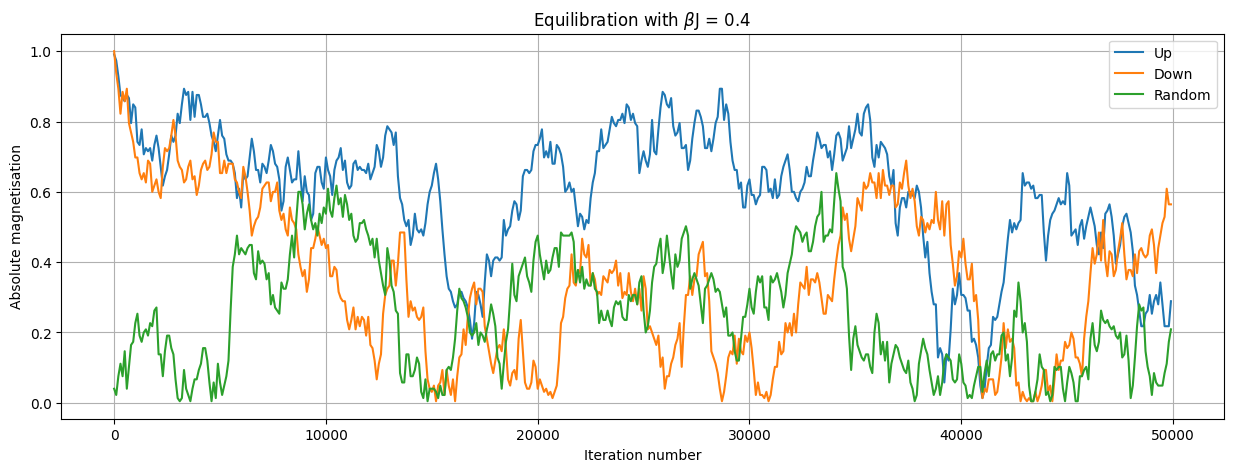

In [71]:
avg_times = np.arange(1,50000,100)

fig, ax = plt.subplots(1,1,figsize=(15,5))

random_0 = np.load(f"Data/MH_equilibration_04/MH_equilibration_04_random.npy", allow_pickle=True)
up_0 = np.load(f"Data/MH_equilibration_04/MH_equilibration_04_up.npy", allow_pickle=True)
down_0 = np.load(f"Data/MH_equilibration_04/MH_equilibration_04_down.npy", allow_pickle=True)

ax.plot(avg_times, up_0, label='Up')
ax.plot(avg_times, down_0, label='Down')
ax.plot(avg_times, random_0, label='Random')
ax.set_title(r'Equilibration with $\beta$J = 0.4')
ax.set_ylabel('Absolute magnetisation')
ax.set_xlabel('Iteration number')
ax.legend()
ax.grid(True)

plt.show()

$\beta$J = 0.4 represents the transition point, due to the high variance in the curves. The high variance makes it difficult to visually check where the distribution becomes stationary. Instead of visual checks, a rolling correlation was calculated between all pairs of curves. A window size of 10 was chosen. This allowed the long-term trends to be observed without losing the short-term fluctuations. Roll_corr_equilibration.py contains the relevant function.

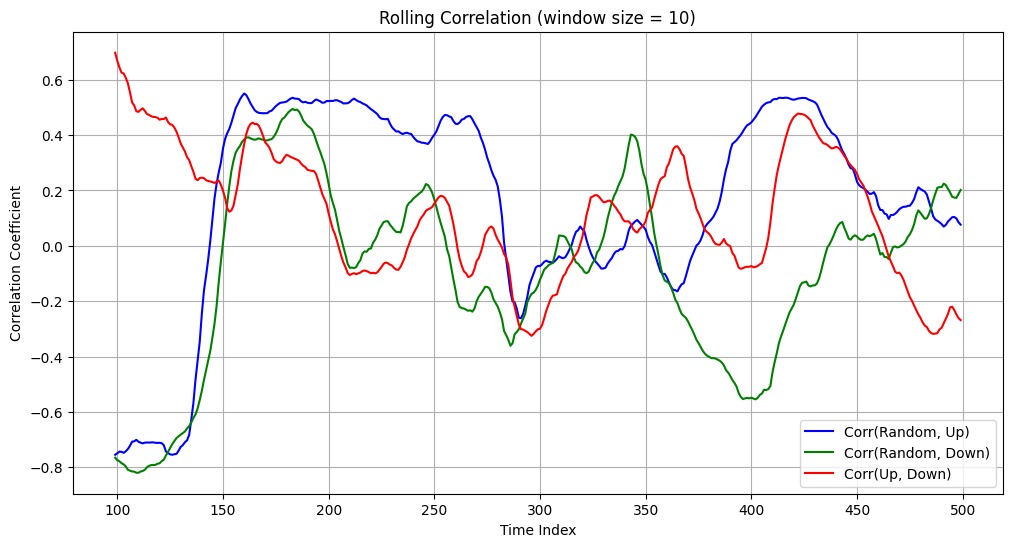

In [72]:
corr_12 = np.load(f"Data/Rolling_correlation_equilibration/Corr(Random, Up).npy", allow_pickle=True)
corr_13 = np.load(f"Data/Rolling_correlation_equilibration/Corr(Random, Down).npy", allow_pickle=True)
corr_23 = np.load(f"Data/Rolling_correlation_equilibration/Corr(Up, Down).npy", allow_pickle=True)

plt.figure(figsize=(12, 6))
plt.plot(corr_12, label='Corr(Random, Up)', color='blue')
plt.plot(corr_13, label='Corr(Random, Down)', color='green')
plt.plot(corr_23, label='Corr(Up, Down)', color='red')
    
plt.title('Rolling Correlation (window size = 10)')
plt.xlabel('Time Index')
plt.ylabel('Correlation Coefficient')
plt.legend()
plt.grid(True)
plt.show()

The graph demonstrates a sharp peak in the correlation coefficient between the random and up (and down) arrangements around 150. This is roughly around 10000 iterations. Afterward, the curves appear to follow the same trend; however, the graph does not provide any concrete conclusions. As the rolling correlation is inconclusive, the autocorrelation was calculated for each curve. The script for this autocorrelation is contained in autocorr_equilibration.py.

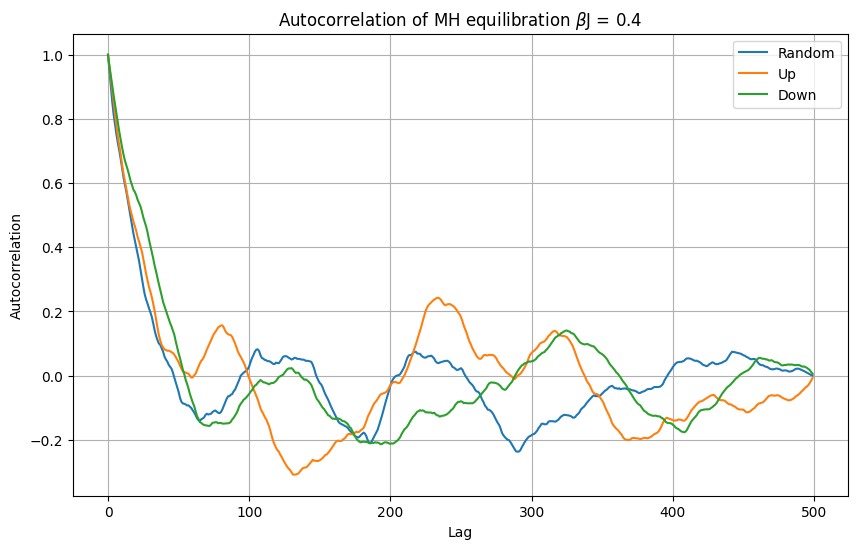

In [73]:
acf1 = np.load(f"Data/autocorr_equilibration/acf_random.npy", allow_pickle=True)
acf2 = np.load(f"Data/autocorr_equilibration/acf_up.npy", allow_pickle=True)
acf3 = np.load(f"Data/autocorr_equilibration/acf_down.npy", allow_pickle=True)

lags = np.arange(len(acf1))

plt.figure(figsize=(10, 6))
plt.plot(lags, acf1, label='Random')
plt.plot(lags, acf2, label='Up')
plt.plot(lags, acf3, label='Down')

plt.title(r'Autocorrelation of MH equilibration $\beta$J = 0.4')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.legend()
plt.grid(True)
plt.show()

The autocorrelation shows a sharp decrease until a lag of 100. 100 corresponds to 10000 iterations. Past this point, the curves oscillate independently. Periodic oscillation and no long-term decay is characteristic of a stationary distribution. It can be concluded that 10000 iterations are sufficient equilibration time for all $\beta$J values.

### 3.3 - Optimal lattice size

Having defined the MH algorithm it is suitable to run some preliminary tests to determine an optimal lattice size, if one such exists. This can be achieved by using the algorithm to approximate the magnetisation curve. The resulting curve can be compared to the known analytical solution by calculating the total linear residual. For robustness, the ordinary least squares approach would provide better analysis. Linear residuals, however, are sufficient for a preliminary test. As the test would be run over large lattice sizes, it was of interest to minimise run time while maintaining adequate accuracy of the approximated curve. Hence, the following code recorded the total linear residual and the run time of the program; averaging over eight iterations and repeating for two different equilibration times. The results are presented in a table afterward.

In [74]:
#%%time
#diff = []
#width = 5

#avg_times = np.arange(1000,10000,1000)
#betaMuHs_analytical = np.linspace(-3,3,100)
#M_analytical = np.tanh(betaMuHs_analytical)

#for i in range(0,8,1):
#    avg_mag = []
#    for val in betaMuHs_analytical:
#        avg_mag.append(np.average(MH.evolve_and_compute_M(setup.init_lattice(width,0),0,val,avg_times)))
#    diff.append(np.sum(np.absolute(avg_mag-M_analytical)))
#print(np.average(diff))

| Lattice width | Average run time (s) | Total linear residue | First cal. of M | Last cal. of M |
|:-------------:|:--------------------:|:--------------------:|:---------------:|:--------------:|
| 15            | 1.44                 | 47.8                 | 100             | 500            |
| 15            | 139                  | 0.859                | 1000            | 10000          |
| 10            | 1.5                  | 27.1                 | 100             | 500            |
| 10            | 139                  | 1.31                 | 1000            | 10000          |
| 5             | 1.58                 | 8.19                 | 100             | 500            |
| 5             | 140                  | 2.61                 | 1000            | 10000          |

The data shows large residuals related to short equilibration times, 47.8 compared to 0.859 for a 15x15 lattice. The lattice must be allowed to reach equilibration therefore longer run times will be seen. However, the program is $\mathcal{O}(N)$, so does not pose a significant problem. Interestingly though, lattice size does not affect the total run time. From these lattice sizes, it would appear that larger lattices have a better correlation; due to the increased sites to average over. Without the run time restriction, this would suggest making the lattice as large as possible. Until now; critical slowing down has not been considered and this is expected to have an effect. Repeating over an increasing range of lattice sizes, data was collated and combined to produce a graph of the total linear residues. Code is found in lattice_size.py but the raw data is presented below.

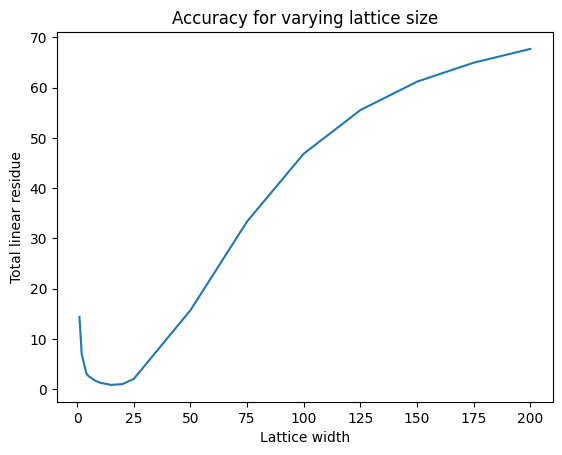

In [75]:
corr = [14.384763320271242, 7.018477407760483, 3.2263520157605323, 2.61, 1.6928439449207089, 1.31, 0.859, 1.028725436218236, 2.067523626573375, 15.715370220367568, 33.3684416874196, 46.84171329235786, 55.51379595902453, 61.167779959024536, 64.93442848510163, 67.67165773680233]
widths = [1,2,4,5,8,10,15,20,25,50,75,100,125,150,175,200]

plt.plot(widths,corr)
plt.xlabel('Lattice width')
plt.ylabel('Total linear residue')
plt.title('Accuracy for varying lattice size')
plt.show()

The graph clearly depicts the onset of critical slowing down. For all future experiments, lattice size will remain in the range of 10 to 25 unless explicitly mentioned otherwise.

### 3.4 - Random Number Generation

The MH algorithm depends on the creation of random numbers. This is achieved through NumPy's BitGenerators. These are not truly random, but rather pseudorandom. For our purpose, we can take these to be random. NumPy offers five BitGenerators, though the main three are PCG-64, MT19937, and SFC64. Each BitGenerator operates differently, though all return a random number. It has been shown that, although these BitGenerators are regarded as "high quality", incorrect answers can be produced [10]. It is therefore necessary to trial the different BitGenerators and select the appropriate one.<br>

To achieve this, the MH algorithm was used to approximate the magnetisation for varying external magnetic field strength. Repeating for each BitGenerator and comparing it with the known analytical solution allows for a fair comparison, with the ability to reject any that do not agree with the analytic solution. Accuracy depends on the runtime duration hence the correlation was calculated for both long and short timescales. The code is contained within the module rng_correlation.py and the results are displayed below.<br>

| PCG-64             |                   | MT19937            |                    | SFC64              |                   |
|--------------------|-------------------|--------------------|--------------------|--------------------|-------------------|
|        Short       |        Long       |        Short       |        Long        |        Short       |        Long       |
| 0.9904302992167997 | 0.999974469491179 | 0.9880609896422623 | 0.9999754634007133 | 0.9899911480901072 | 0.999972824153664 |

MT19937 has the best accuracy for long runtimes with PCG-64 close behind. Short runtimes favour PCG-64. The results show that all BitGenerators have a strong correlation hence provide accurate values for the magnetisation. As such it is sufficient to use NumPy's default BitGenerator, PCG-64.

### 3.5 - SW Algorithm

The next algorithm that simulates the Ising model is the Swendsen-Wang (SW) algorithm. An outline of the general structure was provided in Section 2.5 and relevant functions are contained in the module SW.py. With this algorithm, their was some freedom when building the clusters. In the code, the breadth first search algorithm was used, as done by Wende and Steinke (2013) [11]. Initial visualisation of the time evolution of the lattice is shown below for $\beta$J values of 0.1, 0.4, and 1.5. Data was gathered using SW_Gather_plot_data.py

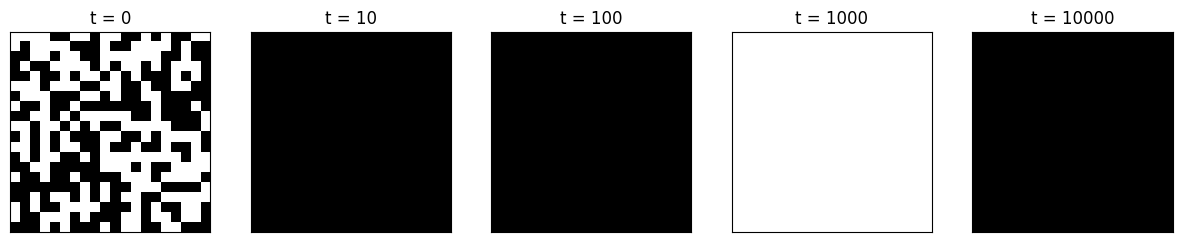

In [76]:
'''L = 20, betaJ = 1.5, betaMuH = 0'''

plot_times = [0,10,100,1000,10000]
fig, ax = plt.subplots(1,len(plot_times),figsize=(15,5))

for i in plot_times:
    plot = np.load(f"Data/SW_test_20_1.5/plot_{i}.npy", allow_pickle=True)
    setup.plot_lattice(plot,ax[plot_times.index(i)],"t = {}".format(i))
    
plt.show()

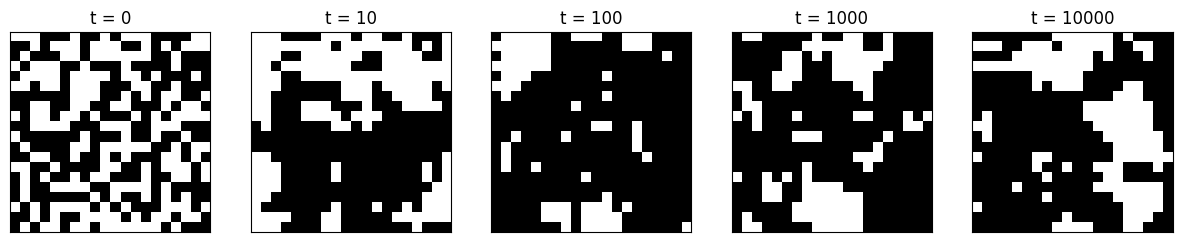

In [77]:
'''L = 20, betaJ = 0.4, betaMuH = 0'''

plot_times = [0,10,100,1000,10000]
fig, ax = plt.subplots(1,len(plot_times),figsize=(15,5))

for i in plot_times:
    plot = np.load(f"Data/SW_test_20_0.4/plot_{i}.npy", allow_pickle=True)
    setup.plot_lattice(plot,ax[plot_times.index(i)],"t = {}".format(i))
    
plt.show()

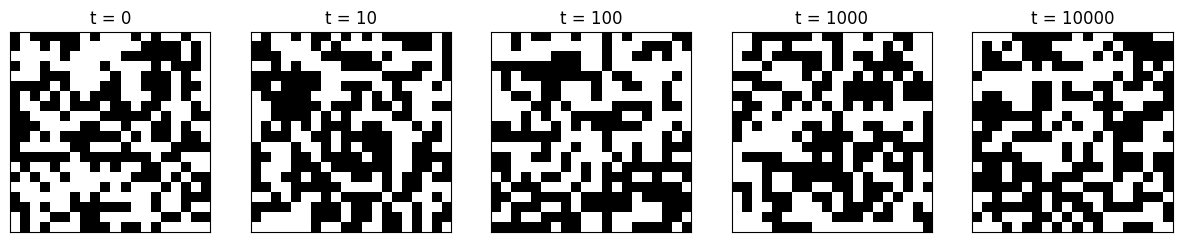

In [78]:
'''L = 20, betaJ = 0.1, betaMuH = 0'''

plot_times = [0,10,100,1000,10000]
fig, ax = plt.subplots(1,len(plot_times),figsize=(15,5))

for i in plot_times:
    plot = np.load(f"Data/SW_test_20_0.1/plot_{i}.npy", allow_pickle=True)
    setup.plot_lattice(plot,ax[plot_times.index(i)],"t = {}".format(i))
    
plt.show()

Each evolution produces the expected final stage (t=10000) lattice. The intermediate value of $\beta$J = 0.4 shows the speed at which clusters are formed using the SW algorithm. This is expected to be fast due to multiple clusters being formed in each interation. These clusters remain even for large times. At strong coupling the entire lattice is quickly incorporated into the cluster. It is expected that cluster size should depend on the degree of coupling.<br>

Having checked the lattice evolution, the absolute magnetisation will be compared to Onsager's solution. Using Mag_comparison.py, the absolute magnetisation was plotted using the SW algorithm. A lattice size of 50 was used and the critical temperature is shown.

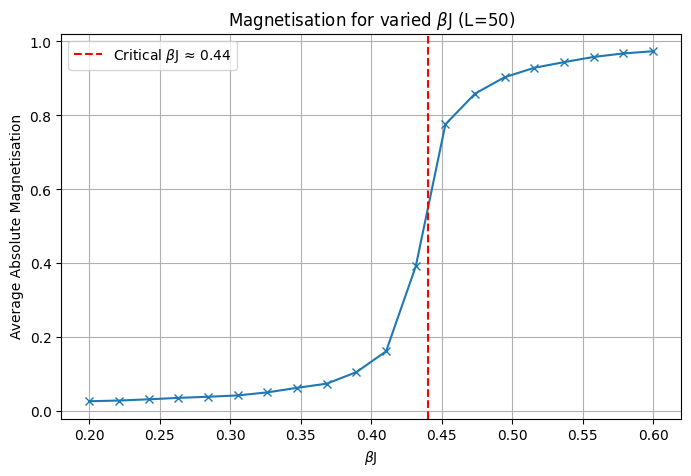

In [79]:
M = np.load('Data/mag_comparison.npy', allow_pickle=True)
betaJs = np.linspace(0.2,0.6,20)

plt.figure(figsize=(8,5))
plt.plot(betaJs, M[1], marker='x')
plt.axvline(0.44, color='r', linestyle='--', label=r'Critical $\beta$J ≈ 0.44')
plt.xlabel(r'$\beta$J')
plt.ylabel('Average Absolute Magnetisation')
plt.title(r'Magnetisation for varied $\beta$J (L=50)')
plt.grid(True)
plt.legend()
plt.show()

The plot shows a good match to the analytic solution. Deviation around the critical is expected due to critical slowing down. Running the simulation for longer would improve the curve.<br> 

As with the MH algorithm, the equilibration of the absolute magnetisation was investigated for varying $\beta$J values. Using the module SW_Gather_M_data.py the data was gathered for a L=15 lattice. Unlike the MH algorithm $\beta$J values of 0.2, 0.4, and 0.6 was used. The graphs for 0.2 and 0.6 are shown first with 0.4 afterwards.

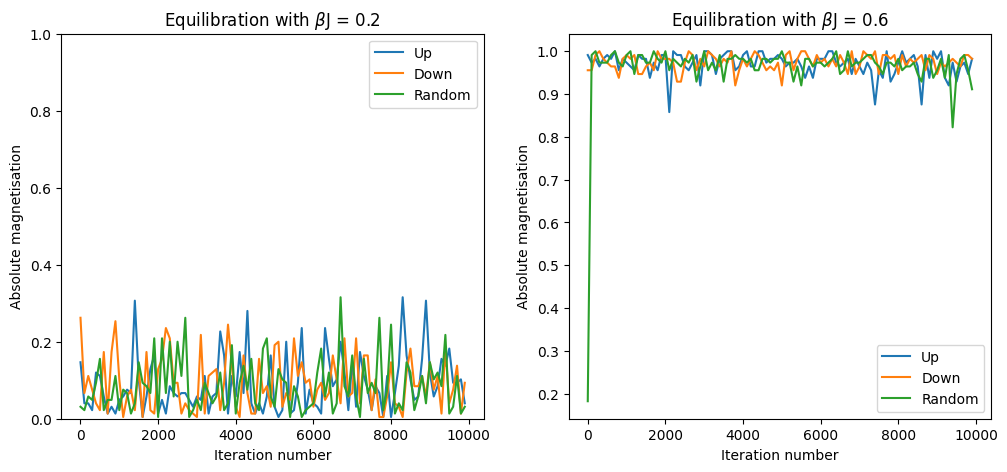

In [80]:
avg_times = np.arange(1,10000,100)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

random_02 = np.load(f"Data/SW_equilibration_02/SW_equilibration_0.2_random.npy", allow_pickle=True)
up_02 = np.load(f"Data/SW_equilibration_02/SW_equilibration_0.2_up.npy", allow_pickle=True)
down_02 = np.load(f"Data/SW_equilibration_02/SW_equilibration_0.2_down.npy", allow_pickle=True)

random_06 = np.load(f"Data/SW_equilibration_06/SW_equilibration_0.6_random.npy", allow_pickle=True)
up_06 = np.load(f"Data/SW_equilibration_06/SW_equilibration_0.6_up.npy", allow_pickle=True)
down_06 = np.load(f"Data/SW_equilibration_06/SW_equilibration_0.6_down.npy", allow_pickle=True)

ax[0].plot(avg_times, up_02, label='Up')
ax[0].plot(avg_times, down_02, label='Down')
ax[0].plot(avg_times, random_02, label='Random')
ax[0].set_title(r'Equilibration with $\beta$J = 0.2')
ax[0].set_ylabel('Absolute magnetisation')
ax[0].set_xlabel('Iteration number')
ax[0].set_ylim(0,1)
ax[0].legend()

ax[1].plot(avg_times, up_06, label='Up')
ax[1].plot(avg_times, down_06, label='Down')
ax[1].plot(avg_times, random_06, label='Random')
ax[1].set_title(r'Equilibration with $\beta$J = 0.6')
ax[1].set_ylabel('Absolute magnetisation')
ax[1].set_xlabel('Iteration number')
ax[1].legend()
    
plt.show()

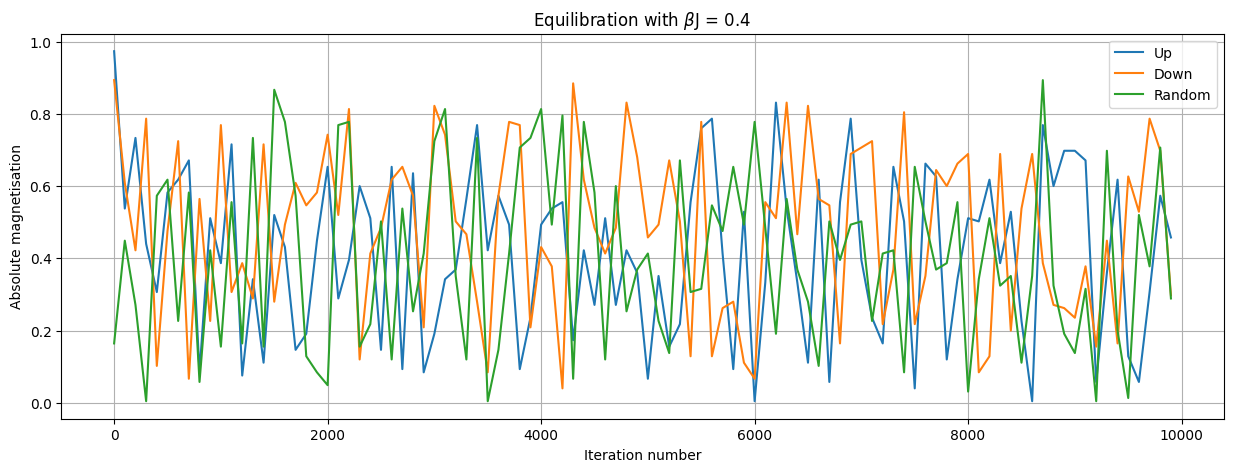

In [81]:
avg_times = np.arange(1,10000,100)

fig, ax = plt.subplots(1,1,figsize=(15,5))

random_0 = np.load(f"Data/SW_equilibration_04/SW_equilibration_0.4_random.npy", allow_pickle=True)
up_0 = np.load(f"Data/SW_equilibration_04/SW_equilibration_0.4_up.npy", allow_pickle=True)
down_0 = np.load(f"Data/SW_equilibration_04/SW_equilibration_0.4_down.npy", allow_pickle=True)

ax.plot(avg_times, up_0, label='Up')
ax.plot(avg_times, down_0, label='Down')
ax.plot(avg_times, random_0, label='Random')
ax.set_title(r'Equilibration with $\beta$J = 0.4')
ax.set_ylabel('Absolute magnetisation')
ax.set_xlabel('Iteration number')
ax.legend()
ax.grid(True)

plt.show()

Firstly, the algorithm was stopped at 10000 iterations. This is significantly less than that for the MH algorithm. Although less iterations were performed, equilibration was still observed. Visually, a value of 2000 iterations is sufficient enough for acceptable equilibration. The graphs exclude the initial absolute magnetisation. For the up and down arrangements, this would be equal to one. For most values of $\beta$J, there is not significant deviation seen from the first pass. Therefore, the graphs appear to start close to one for these arrangements. At low coupling values, this was not observed. The curves start at much lower values. Formation of multiple clusters can explain this. On the first pass, the probability of clusters having more than three members is very low. It is not uncommon for clusters to contain only one spin state. These individual states are then flipped with probability 0.5, resulting in a random distribution. This is significantly different to the original arrangement, even with a single iteration.

### 3.6 - Wolff Algorithm

The final algorithm is the Wolff algorithm. An outline of the algorithm was given in Section 2.5 along with the SW algorithm. Simulation code is contained within the Wolff.py module. Using the Wolff_Gather_plot_data.py module, the time evolution of the lattice is shown below. Each series has a different $\beta$J, matching the SW algorithm. 

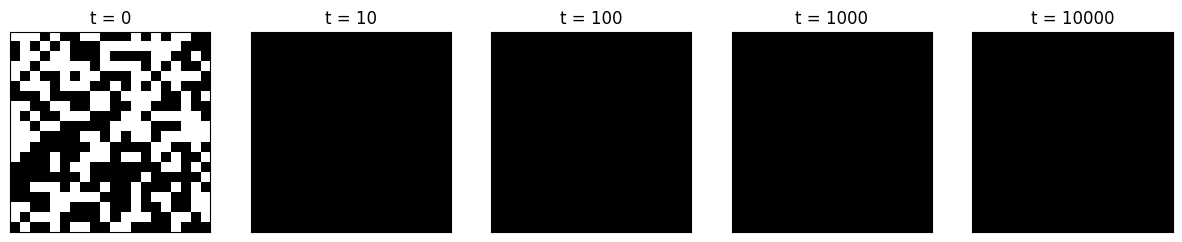

In [82]:
'''L = 20, betaJ = 1.5, betaMuH = 0'''

plot_times = [0,10,100,1000,10000]
fig, ax = plt.subplots(1,len(plot_times),figsize=(15,5))

for i in plot_times:
    plot = np.load(f"Data/Wolff_test_20_1.5/plot_{i}.npy", allow_pickle=True)
    setup.plot_lattice(plot,ax[plot_times.index(i)],"t = {}".format(i))
    
plt.show()

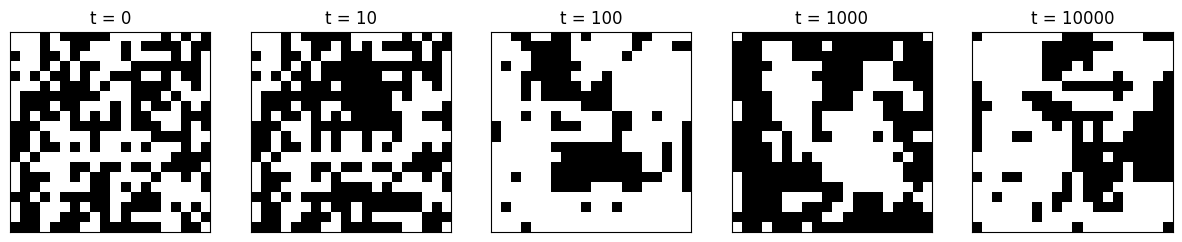

In [83]:
'''L = 20, betaJ = 0.4, betaMuH = 0'''

plot_times = [0,10,100,1000,10000]
fig, ax = plt.subplots(1,len(plot_times),figsize=(15,5))

for i in plot_times:
    plot = np.load(f"Data/Wolff_test_20_0.4/plot_{i}.npy", allow_pickle=True)
    setup.plot_lattice(plot,ax[plot_times.index(i)],"t = {}".format(i))
    
plt.show()

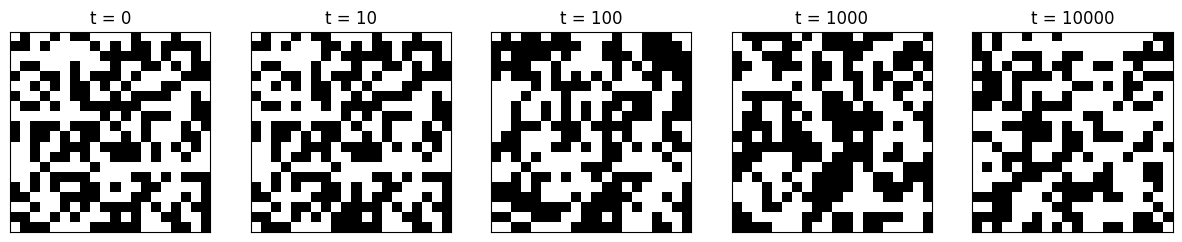

In [84]:
'''L = 20, betaJ = 0.1, betaMuH = 0'''

plot_times = [0,10,100,1000,10000]
fig, ax = plt.subplots(1,len(plot_times),figsize=(15,5))

for i in plot_times:
    plot = np.load(f"Data/Wolff_test_20_0.1/plot_{i}.npy", allow_pickle=True)
    setup.plot_lattice(plot,ax[plot_times.index(i)],"t = {}".format(i))
    
plt.show()

The evolutions observed are as expected. Like with the SW algorithm, clustering can be seen at $\beta$J = 0.4 and at high coupling (0.6) the entire lattice is contained in the cluster.<br>

As with the SW algorithm, the Wolff algorithm should be checked against Onsager's solution. The graph is shown below using the same parameters as for the SW algorithm.

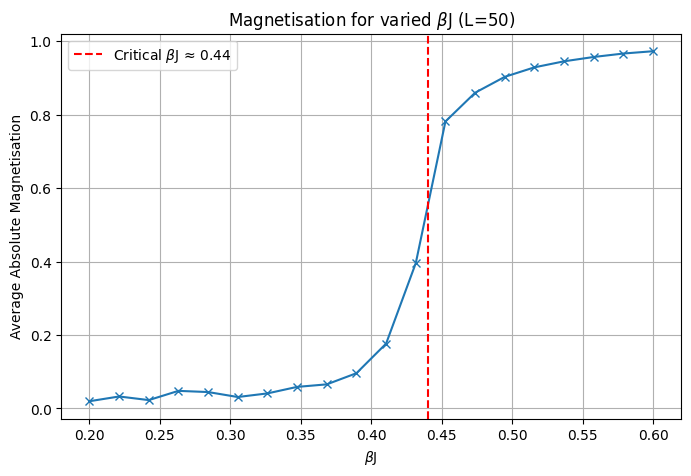

In [85]:
M = np.load('Data/mag_comparison.npy', allow_pickle=True)
betaJs = np.linspace(0.2,0.6,20)

plt.figure(figsize=(8,5))
plt.plot(betaJs, M[0], marker='x')
plt.axvline(0.44, color='r', linestyle='--', label=r'Critical $\beta$J ≈ 0.44')
plt.xlabel(r'$\beta$J')
plt.ylabel('Average Absolute Magnetisation')
plt.title(r'Magnetisation for varied $\beta$J (L=50)')
plt.grid(True)
plt.legend()
plt.show()

Again, the graph is consistent with Onsager's solution. Deviation due to critical slowing down is seen again around the critical temperature.<br>

Equilibration data is shown below using the same $\beta$J values as for the SW algorithm. Module Wolff_Gather_M_data.py was used to produce the data sets.

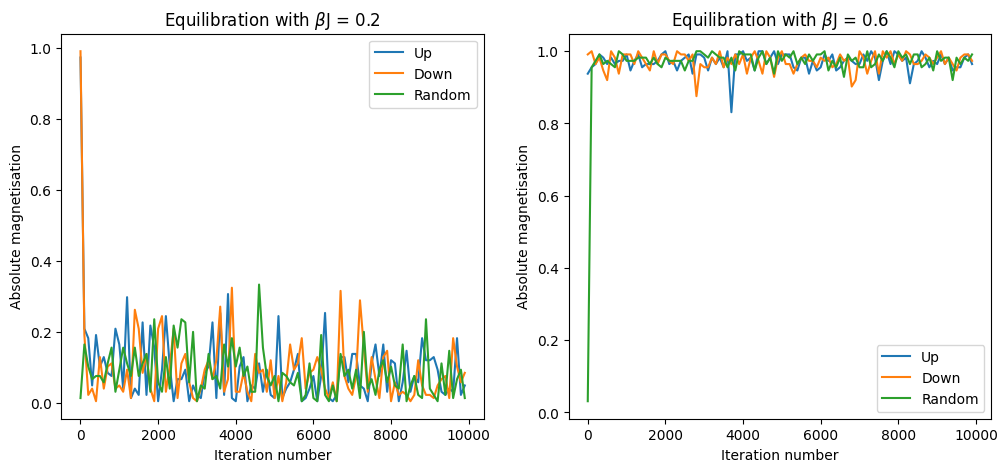

In [86]:
avg_times = np.arange(1,10000,100)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

random_02 = np.load(f"Data/Wolff_equilibration_02/Wolff_equilibration_0.2_random.npy", allow_pickle=True)
up_02 = np.load(f"Data/Wolff_equilibration_02/Wolff_equilibration_0.2_up.npy", allow_pickle=True)
down_02 = np.load(f"Data/Wolff_equilibration_02/Wolff_equilibration_0.2_down.npy", allow_pickle=True)

random_06 = np.load(f"Data/Wolff_equilibration_06/Wolff_equilibration_0.6_random.npy", allow_pickle=True)
up_06 = np.load(f"Data/Wolff_equilibration_06/Wolff_equilibration_0.6_up.npy", allow_pickle=True)
down_06 = np.load(f"Data/Wolff_equilibration_06/Wolff_equilibration_0.6_down.npy", allow_pickle=True)

ax[0].plot(avg_times, up_02, label='Up')
ax[0].plot(avg_times, down_02, label='Down')
ax[0].plot(avg_times, random_02, label='Random')
ax[0].set_title(r'Equilibration with $\beta$J = 0.2')
ax[0].set_ylabel('Absolute magnetisation')
ax[0].set_xlabel('Iteration number')
ax[0].legend()

ax[1].plot(avg_times, up_06, label='Up')
ax[1].plot(avg_times, down_06, label='Down')
ax[1].plot(avg_times, random_06, label='Random')
ax[1].set_title(r'Equilibration with $\beta$J = 0.6')
ax[1].set_ylabel('Absolute magnetisation')
ax[1].set_xlabel('Iteration number')
ax[1].legend()
    
plt.show()

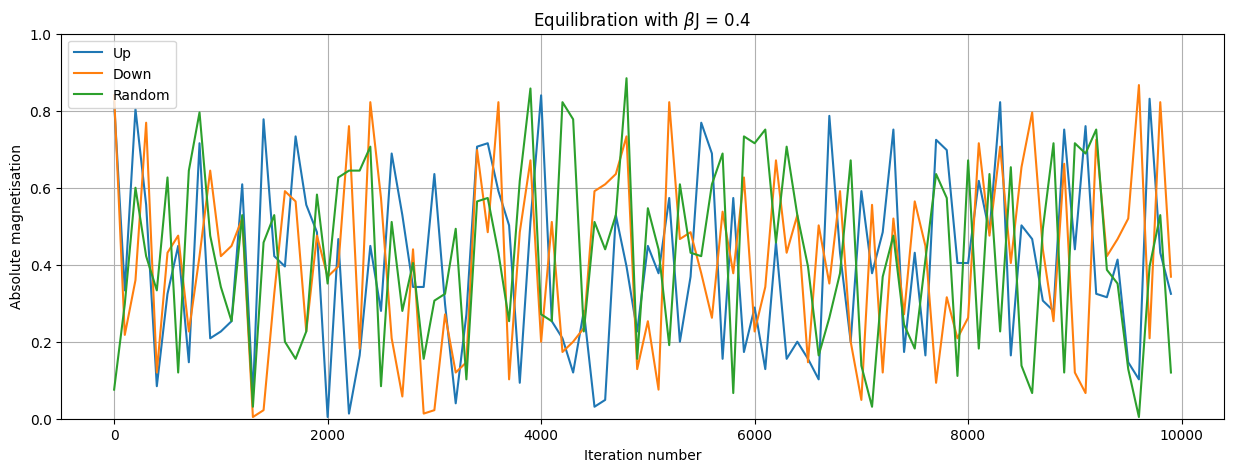

In [87]:
avg_times = np.arange(1,10000,100)

fig, ax = plt.subplots(1,1,figsize=(15,5))

random_0 = np.load(f"Data/Wolff_equilibration_04/Wolff_equilibration_0.4_random.npy", allow_pickle=True)
up_0 = np.load(f"Data/Wolff_equilibration_04/Wolff_equilibration_0.4_up.npy", allow_pickle=True)
down_0 = np.load(f"Data/Wolff_equilibration_04/Wolff_equilibration_0.4_down.npy", allow_pickle=True)

ax.plot(avg_times, up_0, label='Up')
ax.plot(avg_times, down_0, label='Down')
ax.plot(avg_times, random_0, label='Random')
ax.set_title(r'Equilibration with $\beta$J = 0.4')
ax.set_ylabel('Absolute magnetisation')
ax.set_xlabel('Iteration number')
ax.legend()
ax.set_ylim(0,1)
ax.grid(True)

plt.show()

Like with the SW algoritm, only 10000 iterations were performed and 2000 iterations would provide sufficient equilibration time. $\beta$J = 0.4 is seen to oscillate wildly over all possible values of absolute magnetisation. 0.4 is close to the critical temperature of the model. Wild oscillations correspond to the algorithm exploring all phase space for this lattice. The algorithm achieves this through having many different sized clusters in each iteration.

### 3.7 - Autocorrelation

Autocorrelation was discussed in Section 2.1 and is a useful way to quantify the performance or efficiency of an algorithm. In particular, the autocorrelation time provides a way to quantify effects such as critical slowing down. A preliminary test was carried out before calculating the autocorrelation time. This involved graphing the autocorrelation function of the absolute magnetisation for all three algorithms. The variables $\beta$J and L were fixed at 0.4 and 15 respectively. Equilibration of the system was achieved using the relevant number of iterations calculated earlier. Due to the data for the MH algorithm being five times longer than that of Wolff and SW, different lags were applied. A lag of 100 was used for the MH algorithm and 20 was used for the other two. The test aimed to provide a first insight into the shape of the autocorrelation function. For the following section autocorrelation data was gathered using the autocorrelation.py (for MH and Wolff) and autocorrelation_SW.py (SW). Separate modules were used as SW used different lattice widths to MH and Wolff.<br>

To calculate the autocorrelation the library statsmodels was used, specifically the function acf(). Although I had previously written a function that calculates the autocorrelation function for the equilibration analysis, it was decided that using statsmodels would provide a better analysis. Statsmodels would also provide more freedom to work with other statistical functions if they should be required.

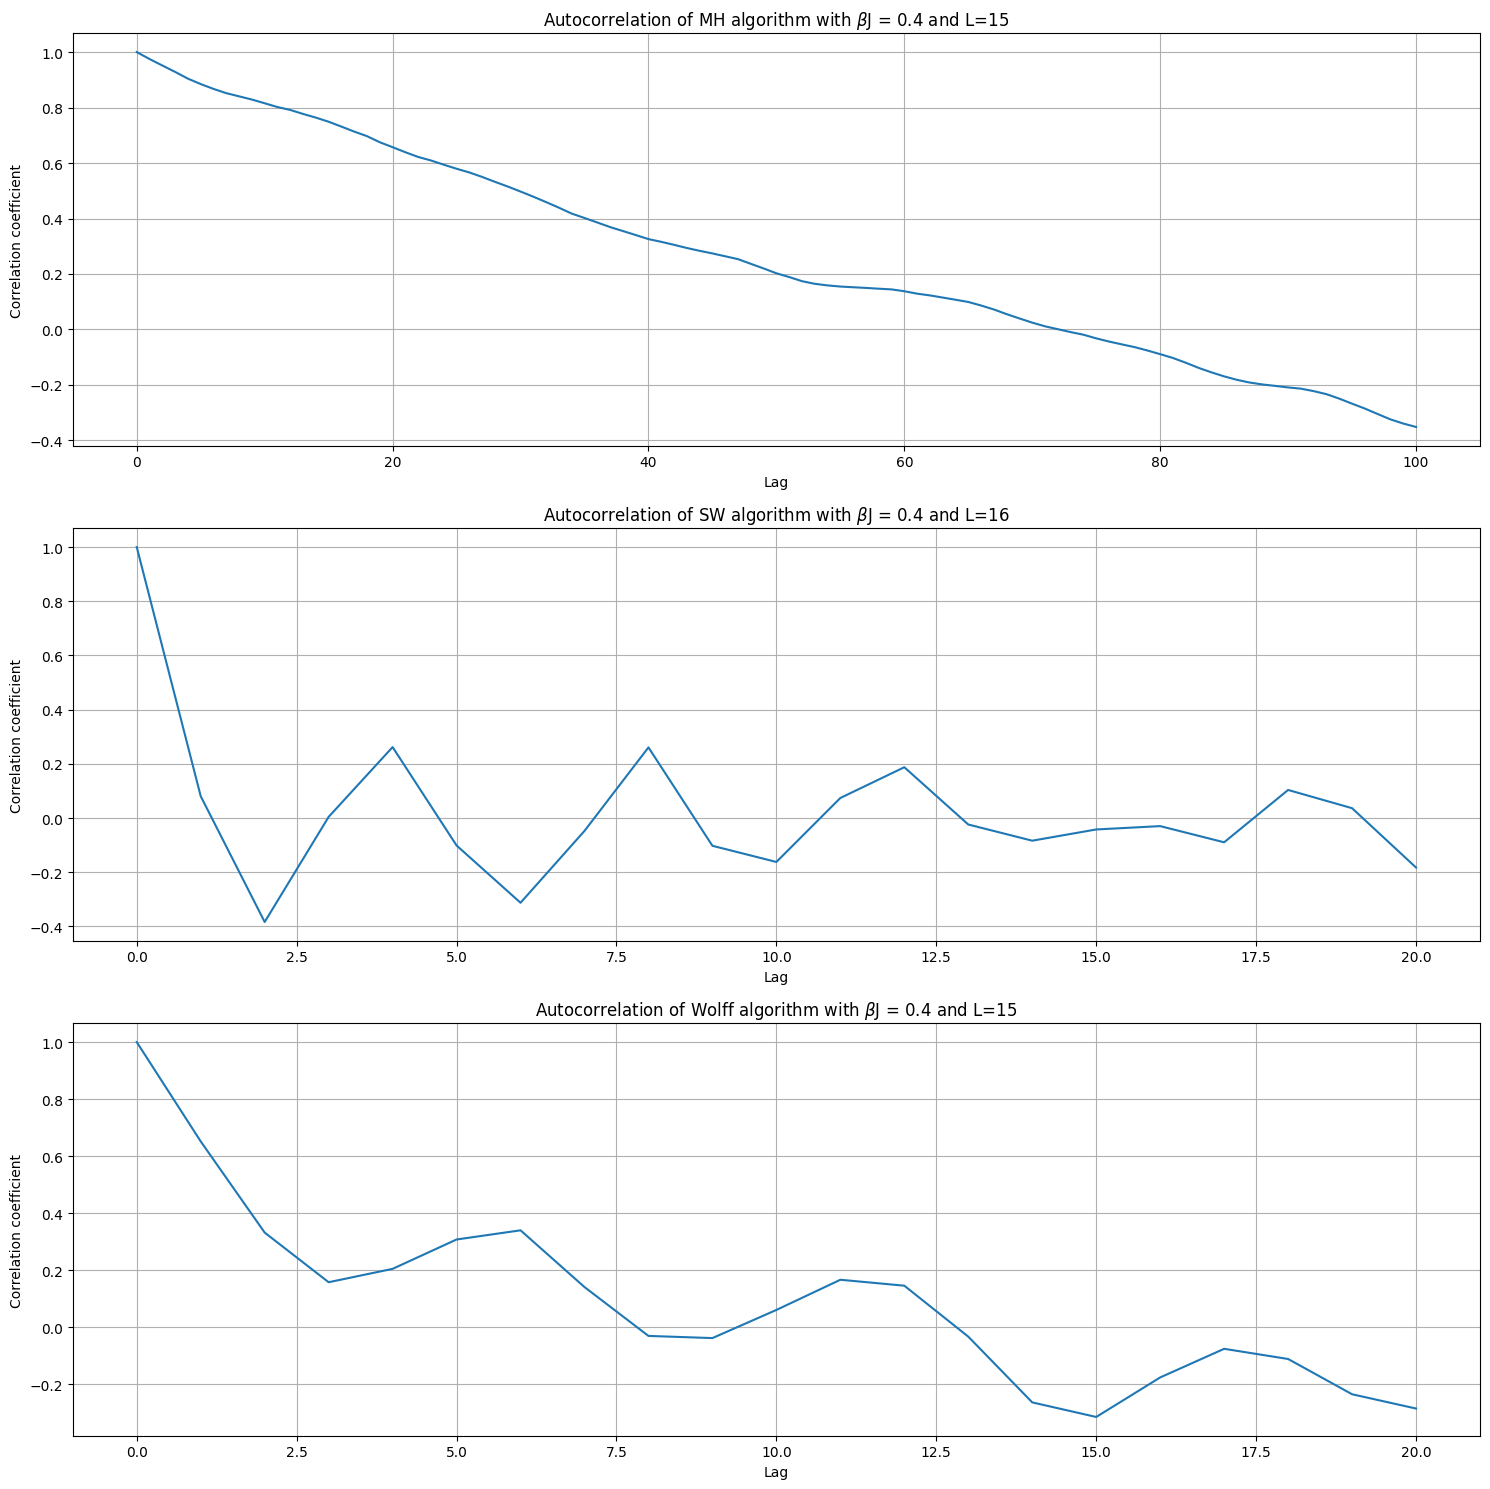

In [88]:
data_MH = np.load("Data/Autocorrelation/MH_L_4.npy", allow_pickle=True)
data_SW = np.load("Data/Autocorrelation/SW_L_4.npy", allow_pickle=True)
data_Wolff = np.load("Data/Autocorrelation/Wolff_L_4.npy", allow_pickle=True)

fig, ax = plt.subplots(3)

ax[0].plot(data_MH[0])
ax[0].set_title(r'Autocorrelation of MH algorithm with $\beta$J = 0.4 and L=15')
ax[0].set_ylabel('Correlation coefficient')
ax[0].set_xlabel('Lag')
ax[0].grid(True)

ax[1].plot(data_SW[0])
ax[1].set_title(r'Autocorrelation of SW algorithm with $\beta$J = 0.4 and L=16')
ax[1].set_ylabel('Correlation coefficient')
ax[1].set_xlabel('Lag')
ax[1].grid(True)

ax[2].plot(data_Wolff[7])
ax[2].set_title(r'Autocorrelation of Wolff algorithm with $\beta$J = 0.4 and L=15')
ax[2].set_ylabel('Correlation coefficient')
ax[2].set_xlabel('Lag')
ax[2].grid(True)

fig.set_figheight(15)
fig.set_figwidth(15)
fig.tight_layout()
plt.show()

The graphs clearly show a decay in the correlation coefficient, typical of an autocorrelation function. Decay in the MH algorithm is much slower than that for Wolff and SW, which should be expected. This justifies using a longer lag for the MH algorithm, as in the first 20 steps the coefficient is still higher than 0.6. Initially, the MH algorithm does not appear to show an exponential decay; this could introduce some problems when calculating the autocorrelation time. Both SW and Wolff show a decay that appears exponential-like. The test confirms the code appears to be working as it should.<br>

Having completed the preliminary test, the dependence of the autocorrelation function can be investigated on the different variables. Two variables can be varied: $\beta$J or L. Changing $\beta$J would provide insight into critical slowing down. One would expect to observe a peak in the autocorrelation time around the critical temperature. Better performance would be encoded into the height of the peak. The MH algorithm would be expected to perform the worst and SW should perform the best. This would be a good visual guide for demonstrating critical slowing down, alternatively, L is varied in this report. Fixing $\beta$J and varying L allows for the dynamic exponent (z) to be estimated. With z taking a different value for each algorithm, the performance of each algorithm can be quantified. Better algorithms have a value for z closer to zero. Though in literature values between 0.19 and 2.2 have been measured [12]. The MH algorithm is expected to have a value close to 2.2 and Wolff and SW should have values closer to 0.19.<br>

Firstly, the autocorrelation functions are plotted for each algorithm below for different L. Error bars are not shown as the plots are already crowded and introducing error bars will limit visibility. Run time of the SW, investigated in Section 3.8, placed a significant limit on the size of the lattice (L). This meant that the SW algorithm was restricted to lattices of the size 2-24. MH and Wolff algorithms had much faster computations hence the lattices up to L=4096 were graphed.

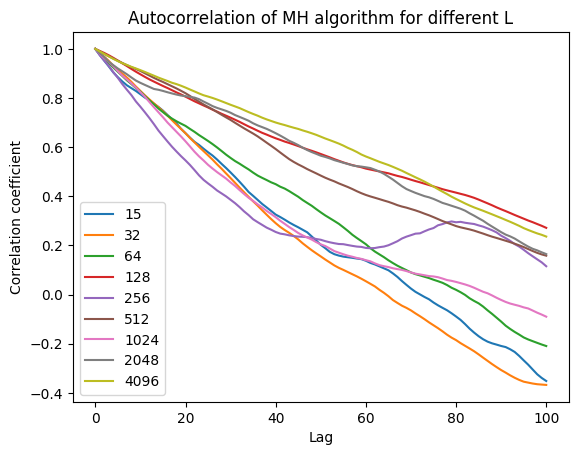

In [89]:
data_MH = np.load("Data/Autocorrelation/MH_L_4.npy", allow_pickle=True)
L = [15, 32, 64, 128, 256, 512, 1024, 2048, 4096]

fig, ax = plt.subplots()

for i in range(9):
    ax.plot(data_MH[i], label=f'{L[i]}')

ax.set_title(r'Autocorrelation of MH algorithm for different L')
ax.set_ylabel('Correlation coefficient')
ax.set_xlabel('Lag')
plt.legend()
plt.show()

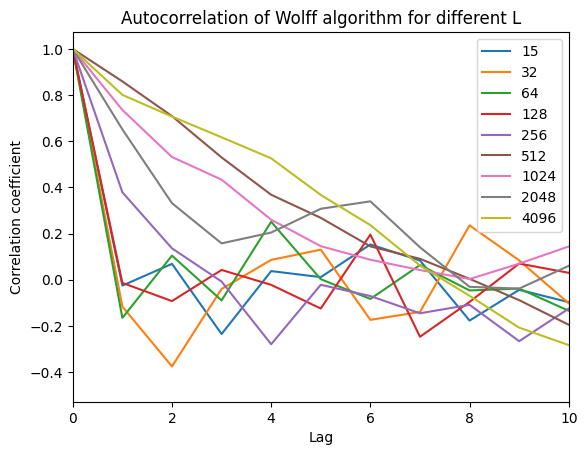

In [90]:
data_Wolff = np.load("Data/Autocorrelation/Wolff_L_4.npy", allow_pickle=True)
L = [15, 32, 64, 128, 256, 512, 1024, 2048, 4096]

fig, ax = plt.subplots()

for i in range(9):
    ax.plot(data_Wolff[i], label=f'{L[i]}')

ax.set_title(r'Autocorrelation of Wolff algorithm for different L')
ax.set_ylabel('Correlation coefficient')
ax.set_xlabel('Lag')
ax.set_xlim(0,10)
plt.legend()
plt.show()

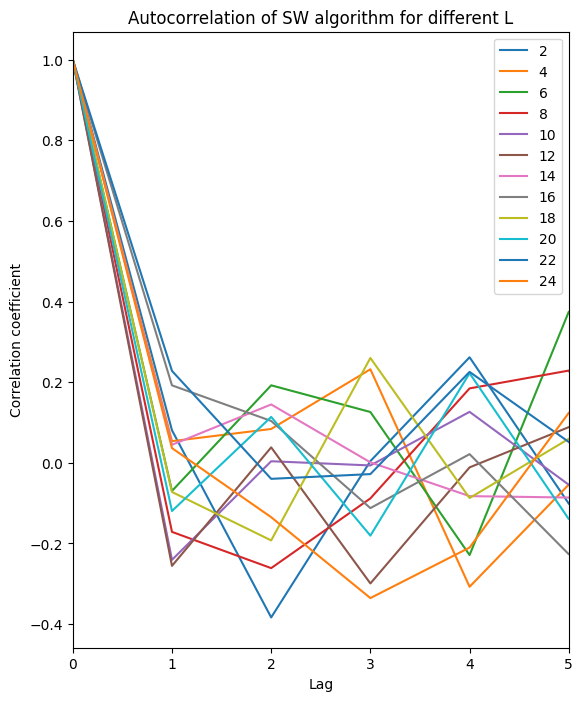

In [91]:
data_SW = np.load("Data/Autocorrelation/SW_L_4.npy", allow_pickle=True)
L = np.arange(2,26,2)

fig, ax = plt.subplots()

for i in range(12):
    ax.plot(data_SW[i], label=f'{L[i]}')

ax.set_title(r'Autocorrelation of SW algorithm for different L')
ax.set_ylabel('Correlation coefficient')
ax.set_xlabel('Lag')
fig.set_figheight(8)
ax.set_xlim(0,5)
plt.legend()
plt.show()

The graphs show that with extending the lattice size the autocorrelation time increases. Some outliers are seen but this is likely down to favourable arrangements that would result in a faster decorrelation. Looking at the curves for the MH algorithm, you can see an exponential shape for some of the lattice sizes but most remain fairly linear.<br>

Next, the autocorrelation times need to be calculated. This was achieved by taking the log of the data and fitting a linear curve to the transformed data. The slope gave the value of the exponent for the appropriate decaying exponential. By taking the negative reciprocal of the slope, the autocorrelation time was estimated. Difficulties arose here due to some curves taking negative values. When dealing with this problem, two approaches were considered. The first involved taking the absolute value of the array before applying the log. This method would work if the data was symmetric about zero correlation coefficient. However, for this data, large (sometimes negative) autocorrelation times were returned. A second approach was considered and subsequently utilised. This involved removing data points that were negative. Though not ideal, this method will likely overestimate the autocorrelation time. Applying the approach returned times similar to values estimated from visual estimating when the curve falls below 1/e. It was decided that these values were accurate enough for the analysis. This was achieved within the modules autocorr_time_MH.py, autocorr_time_SW.py and autocorr_time_Wolff.py<br>

Finally, the dynamic exponent was calculated. Contained in the same modules as the autocorrelation time, a regression was performed on the logged data. The critical exponent could be read off as the value of the slope. Graphs are shown below.

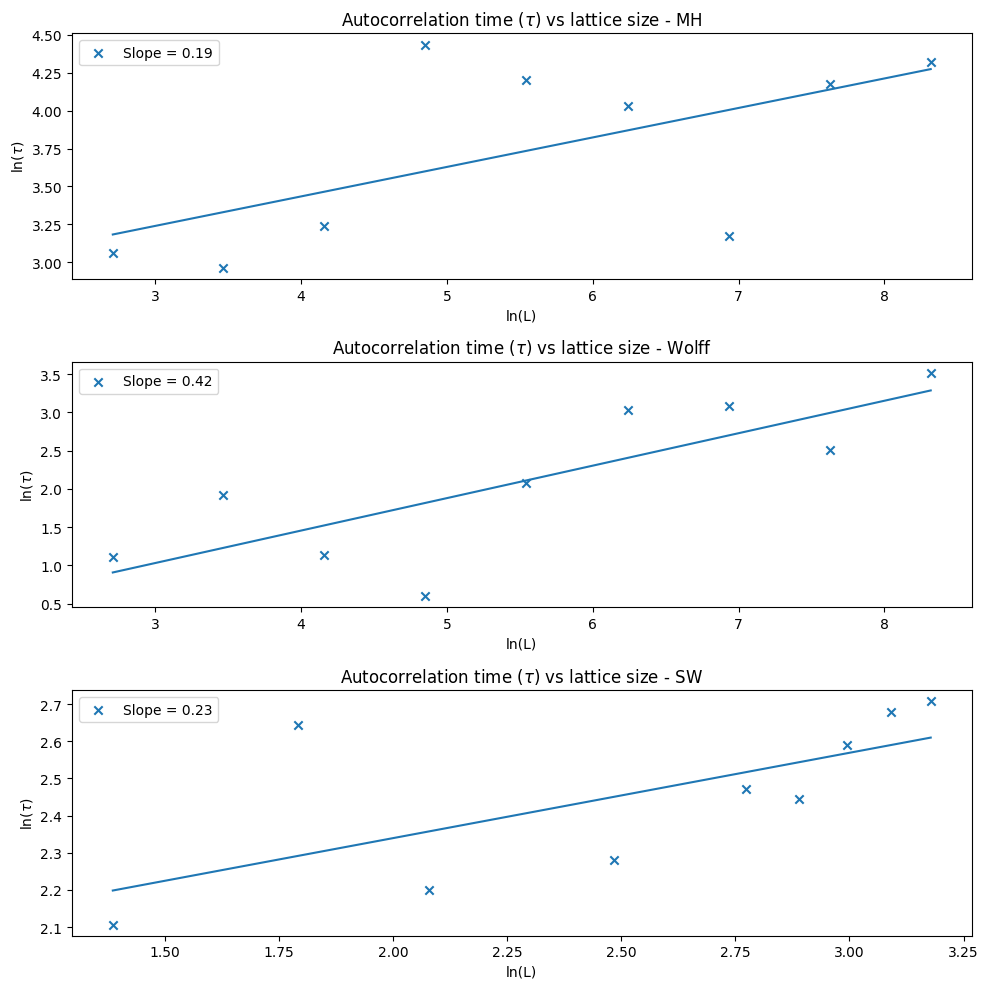

In [92]:
Lat = [15, 32, 64, 128, 256, 512, 1024, 2048, 4096]
Lat_SW = np.arange(2,26,2)
autocorr_times_Wolff = np.load('Data/Autocorrelation_time/autocorr_time_Wolff.npy')
slopeW, interceptW, rW, pW, std_errW = stats.linregress(np.log(Lat), np.log(autocorr_times_Wolff))
lineW = slopeW * np.log(Lat) + interceptW

autocorr_times_MH = np.load('Data/Autocorrelation_time/autocorr_time_MH.npy')
slopeMH, interceptMH, rMH, pMH, std_errMH = stats.linregress(np.log(Lat), np.log(autocorr_times_MH))
lineMH = slopeMH * np.log(Lat) + interceptMH

autocorr_times_SW = np.load('Data/Autocorrelation_time/autocorr_time_SW.npy')
autocorr_times_SW = np.delete(autocorr_times_SW, [0,4,6])
Lat_SW = np.delete(Lat_SW, [0,4,6])
slopeSW, interceptSW, rSW, pSW, std_errSW = stats.linregress(np.log(Lat_SW), np.log(autocorr_times_SW))
lineSW = slopeSW * np.log(Lat_SW) + interceptSW

fig, ax = plt.subplots(3)

ax[0].scatter(np.log(Lat),np.log(autocorr_times_MH),marker='x',label=f'Slope = {round(slopeMH,2)}')
ax[0].plot(np.log(Lat),lineMH)
ax[0].set_title(r'Autocorrelation time ($\tau$) vs lattice size - MH')
ax[0].set_ylabel(r'ln($\tau$)')
ax[0].set_xlabel('ln(L)')
ax[0].legend()

ax[1].scatter(np.log(Lat),np.log(autocorr_times_Wolff),marker='x',label=f'Slope = {round(slopeW,2)}')
ax[1].plot(np.log(Lat),lineW)
ax[1].set_title(r'Autocorrelation time ($\tau$) vs lattice size - Wolff')
ax[1].set_ylabel(r'ln($\tau$)')
ax[1].set_xlabel('ln(L)')
ax[1].legend()

ax[2].scatter(np.log(Lat_SW),np.log(autocorr_times_SW),marker='x',label=f'Slope = {round(slopeSW,2)}')
ax[2].plot(np.log(Lat_SW),lineSW)
ax[2].set_title(r'Autocorrelation time ($\tau$) vs lattice size - SW')
ax[2].set_ylabel(r'ln($\tau$)')
ax[2].set_xlabel('ln(L)')
ax[2].legend()

fig.set_figheight(10)
fig.set_figwidth(10)
fig.tight_layout()
plt.show()

The slope (dynamic exponent) is shown for each graph. When fitting the curves, the $R^{2}$ value was checked. MH and Wolff had acceptable values; however, SW had a value close to zero. Looking at the graph showed a pattern towards the bottom of the data. This pattern was overshadowed by some large data points. These data points were likely outliers due to a unfavourable arrangement resulting a very large autocorrelation time. To clean the data, the first data point was ignored. This improved the $R^{2}$ value significantly. It was decided that omission of this data point is sufficient enough to demonstrate the trend seen. The data is summarised below along with the expected dynamic exponent.<br>

| Algorithm | Dynamic exponent | $R^{2}$ | Expected dynamic exponent |
|:---------:|:----------------:|:-------:|---------------------------|
| MH        | 0.19             | 0.61    | 1.70-2.2                  |
| Wolff     | 0.42             | 0.80    | 0.19-0.50                 |
| SW        | 0.23             | 0.66    | 0.19-0.25                 |

Clearly, Wolff and SW do very well at estimating the dynamic exponent. However, this is not true for the MH algorithm. The calculated value is off by an order of magnitude. Removing the two data points which could be outliers adjusted the dynamic exponent to 0.25; still too a lot lower than expected. The problem lies within the data as the same code structure is used for all three algorithms. It was noted during the preliminary test that the autocorrelation function looked linear. This is a problem as calculating the autocorrelation time makes the assumption that the autocorrelation function is decaying exponentially. It is believed that the linear dependence may arise from many different reasons. Firstly, the simulation is carried out at $\beta$J=0.4 which is close to the critical temperature but not exact. This will change the dynamic exponent. Also, the simulation was only run for 100 lags, longer run simulations and averaging multiple results should reduce the flucutuations. Fluctuations may result in unsual autocorrelation times being observed, hence effecting the dynamic exponent.

### Model code

Researching potential fixes to the code for the MH algorithm led to the discovery of some model code. The code is contained in an interactive book, summarising a lecture course [13]. NWI-NM042B Monte Carlo Techniques is the course, that was in the Physics & Astronomy master program at Radboud University, Nijmegen, The Netherlands. This code can serve as a comparison to my code. The key difference was the use of sweeps instead of iteration steps. A sweep is defined as the number of iteration steps required for all lattice sites to have been visited. It appears that the model code runs for significantly longer than mine. This could be the source of error in the MH algorithm. Wolff and SW require less time to equilibrate so will not be affected by this effect as much, hence resulting in more accurate dynamic exponent estimates.<br>

Before moving on, some analysis was carried out using the model code. For ease of separation all data gathering and analysis code in contained within the model_code.py module and collected data is contained in the folder Model_data. The first graph produced was of the autocorrelation function for both magnetisation and internal energy.

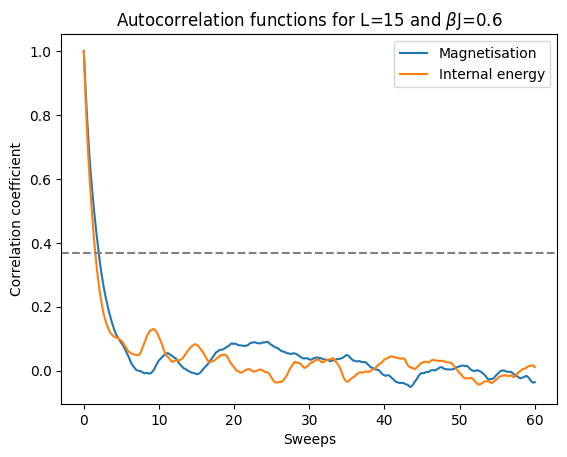

In [93]:
mag_acf = np.load('Data/Model_data/acf_mag.npy', allow_pickle=True)
E_acf = np.load('Data/Model_data/acf_E.npy', allow_pickle=True)

x = np.arange(len(mag_acf[0]))/(15**2)

plt.plot(x,mag_acf[0],label='Magnetisation')
plt.plot(x,E_acf[0],label='Internal energy')
plt.axhline(np.exp(-1),linestyle='--',color='0.5')
plt.xlabel('Sweeps')
plt.ylabel('Correlation coefficient')
plt.title(r'Autocorrelation functions for L=15 and $\beta$J=0.6')
plt.legend()
plt.show()

The graph showsa smooth exponential decay for both magnetisaion and internal energy. There is a small overshot of the x axis but initally the assumption of exponential decay is valid. A dashed line indentifies 1/e.<br>

The next investigation was to calculate the dynamic exponent for this algorithm. Repeating the procedure used before, the slope (dynamic exponent) was estimated. Ten runs were performed on ten lattice sizes between 10 and 25, with $\beta$J fixed at 0.6. This is slightly above the critical temperature so we would expect a dynamic exponent around 2. As critical slowing down is reduced away from the critical temperature. Averaging the different runs gave a value of 1.55 $\pm$ 0.20. This is a significant improvement on the previously estimated value, however, this is still fairly short of the expected value. This would suggest further running or equilibration is required.<br>

Lastly, although not performed using my code, $\beta$J were varied for fixed L. The magnetisation and internal energy was measured. As mentioned earlier, a peak around the critical temperature would be expected. This would show critical slowing down. This experiment was repeated for lattice size L=10,15,20,25. For magnetisation, the peak height was independent of the lattice size, hence to reduce uncertainty the data was averaged. Internal energy did not show this effect, the peak increased with L. A graph of L=10 and L=20 is plotted to demonstrate this effect. It is expected that the peak will lie on the critical temperature, hence the internal energy data was averaged as this should not change the $\beta$J position of the peak. Finally, the data was collected using a data set of $\beta$J that is concentrated around the expected peak value, $\approx$ 0.44. This will give a better resolution around the fast-changing values. To achieve this a tanh warped distribution was used with the peak concentration around 0.4.<br>

An estimate of the peak position was obtained using the fitted gaussian. Magnetisation peaked at 0.41 and internal energy at 0.44. This is consistent with the expected value.

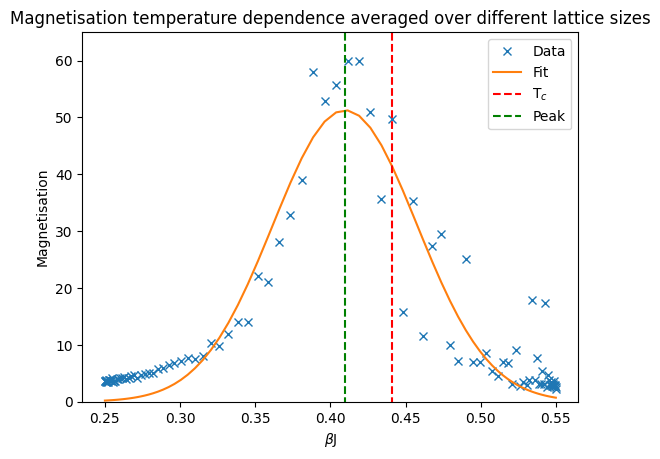

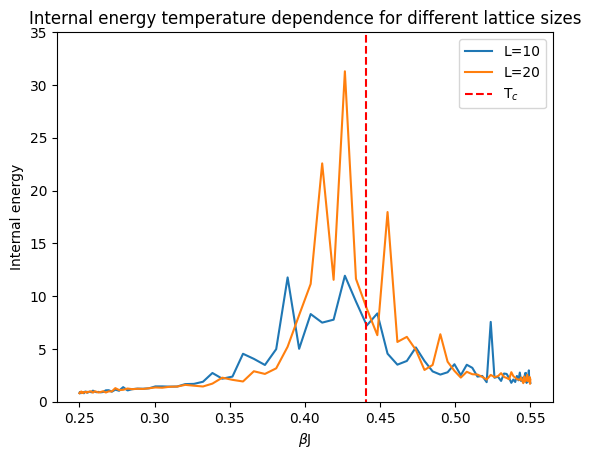

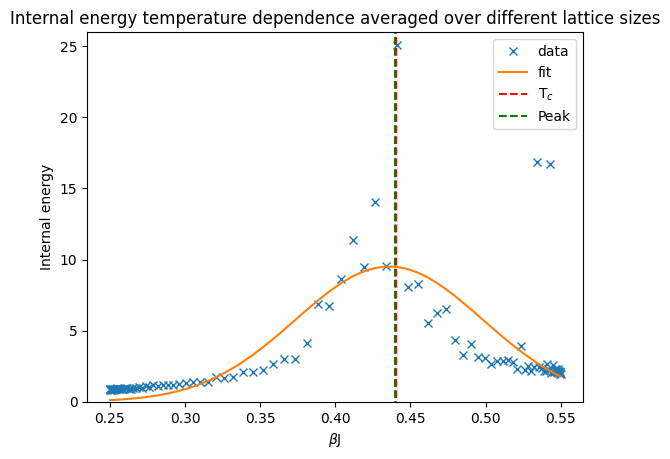

In [94]:
data10 = np.load('Data/Model_data/T_mag_data10.npy', allow_pickle=True)
data15 = np.load('Data/Model_data/T_mag_data15.npy', allow_pickle=True)
data20 = np.load('Data/Model_data/T_mag_data20.npy', allow_pickle=True)
data25 = np.load('Data/Model_data/T_mag_data25.npy', allow_pickle=True)
beta = np.load('Data/Model_data/betas.npy', allow_pickle=True)
mag_fitted = np.load('Data/Model_data/gaus_fit_mag.npy', allow_pickle=True)

average = (data10 + data15 + data20 + data25)/4

plt.plot(beta,average, 'x', label='Data') 
plt.plot(beta,mag_fitted, '-', label='Fit')
plt.vlines(np.log(1+np.sqrt(2))/2,ymin=-0.5,ymax=70,colors='r',linestyle='--',label=r'T$_{c}$')
plt.vlines(0.41,ymin=-0.5,ymax=70,colors='g',linestyle='--',label='Peak')
plt.ylim(0,65)
plt.xlabel(r'$\beta$J')
plt.ylabel('Magnetisation')
plt.title('Magnetisation temperature dependence averaged over different lattice sizes')
plt.legend()
plt.show()

Edata10 = np.load('Data/Model_data/T_E_data10.npy', allow_pickle=True)
Edata15 = np.load('Data/Model_data/T_E_data15.npy', allow_pickle=True)
Edata20 = np.load('Data/Model_data/T_E_data20.npy', allow_pickle=True)
Edata25 = np.load('Data/Model_data/T_E_data25.npy', allow_pickle=True)
E_fitted = np.load('Data/Model_data/gaus_fit_E.npy', allow_pickle=True)

Eaverage = (Edata10 + Edata15 + Edata20 + Edata25)/4

plt.plot(beta, Edata10,label='L=10')
plt.plot(beta, Edata20,label='L=20')
plt.vlines(np.log(1+np.sqrt(2))/2,ymin=-0.5,ymax=70,colors='r',linestyle='--',label=r'T$_{c}$')
plt.ylim(0,35)
plt.xlabel(r'$\beta$J')
plt.ylabel('Internal energy')
plt.title('Internal energy temperature dependence for different lattice sizes')
plt.legend()
plt.show()

plt.plot(beta,Eaverage, 'x', label='data') 
plt.plot(beta,E_fitted, '-', label='fit')
plt.vlines(np.log(1+np.sqrt(2))/2,ymin=-0.5,ymax=70,colors='r',linestyle='--',label=r'T$_{c}$')
plt.vlines(0.44,ymin=-0.5,ymax=70,colors='g',linestyle='--',label='Peak')
plt.ylim(0,26)
plt.xlabel(r'$\beta$J')
plt.ylabel('Internal energy')
plt.title('Internal energy temperature dependence averaged over different lattice sizes')
plt.legend()
plt.show()

### 3.8 - Complexity

The algorithm's complexity is an important consideration when investigating its performance. Complexity is defined as the amount of resources required to run the algorithm. Resources generally refer to the computational time, but the memory storage requirement could also be examined. In the case of this report, time complexity is the most relevant.<br>

Time complexity measures how long it takes for an algorithm to finish. This is commonly recorded by analysing either the wall clock time or the CPU time. Though very similar, there is a slight difference. Wall clock time is affected by the computer environment. Explicitly, the wall clock time will appear larger than the CPU time if the computer has other applications running in the background. It was decided that for the analysis, the difference between wall clock time and CPU time is negligible; providing the same background applications were running.<br>

Variations in time complexity normally arise with the scaling of a system. For example, the number of items a sorting algorithm has to sort through. This variation can be expressed succinctly using the Big O notation. Linear variations are shown as O(n); whereas a quadratic dependence would be O(n$^{2}$). The Ising model has two natural variations that could result in a variation in time complexity: coupling ($\beta$J) and lattice size (L).<br>

Before taking measurements, a theoretical time complexity should be estimated. The scaling of the system provides the basis for analysis. Big O notation states that to estimate the scaling, one should count the number of basic operations. Basic operations include many operations but examples are comparisons, arithmetic operations, data access, and function calls. A good rule of thumb is to count the number of loops present, specifically for loops. Starting with coupling, none of the algorithms loop over $\beta$J values. This suggests that all of the algorithms will be O(1) - constant in time. Looking at lattice size, MH and Wolff algorithms do not loop over the lattice; however, SW algorithm has a double nested for loop over lattice width. This suggests MH and Wolff will have O(1), while the SW will show O(n$^{2}$). Though not relevant to the 2D Ising model with nearest neighbour interactions, the number of neighbours considered might result in a non-constant variation. All algorithms have comparisons between the neighbours. Therefore, it should be expected that extending to more dimensions (or considering next-nearest interactions) will result in a larger runtime. A rough theoretical estimate would have MH = O(n), Wolff = O(n$^{3}$), and SW = O(n$^{5}$). These are obtained by counting the number of nested comparisons and for loops. An improvement to the Wolff algorithm was achieved by using a set to contain the members of the cluster. Sets have an average search time complexity of O(1), with the worst case being O(n). The alternative, lists, have an average time complexity of O(n). By choosing a set over a list, the theoretical time complexity can be reduced. It is expected, though, that this should not have an observable effect.<br>

Armed with the theoretical estimates, measurements were taken for all three algorithms. My code was used for the MH algorithm, instead of the model code. When varying the coupling, it was decided to fix the lattice size at L=15. $\beta$J=1 was used for the variation in the lattice size. In the interest of time, the wall clock time was recorded for the first iteration of the algorithm acting on a random lattice arrangement. The test was run five times and averaged for each algorithm. Relevant functions are contained in the Complexity.py module. The functions return a numpy array that contains the data along with errors. Time was measured using time.time() from the existing Python time module and the errors arose from the standard deviation in the five tests.

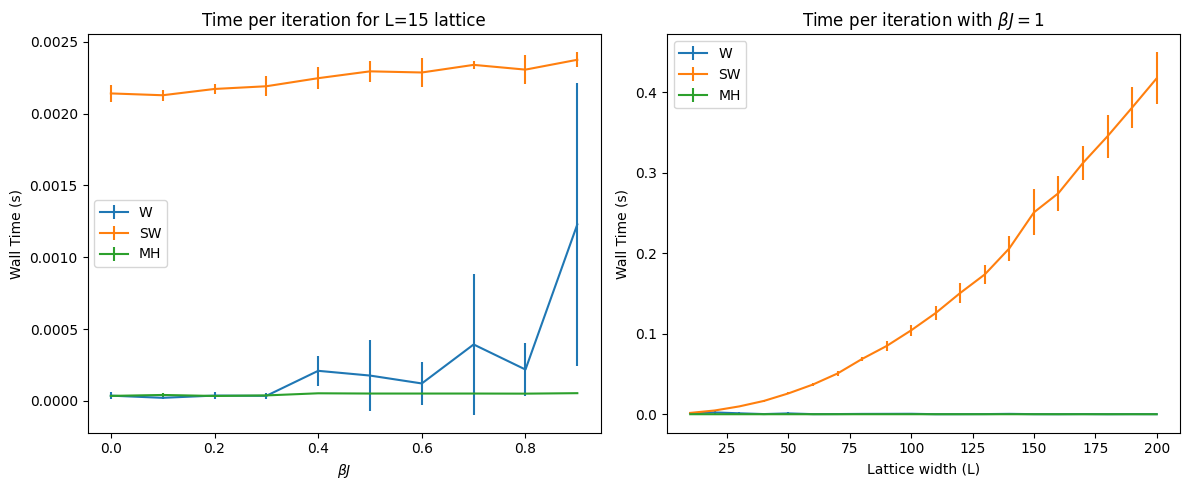

In [95]:
T_data = np.load(f"Data/T_time.npy", allow_pickle=True)
L_data = np.load(f"Data/L_time.npy", allow_pickle=True)

x_T = np.arange(0,10,1)
x_L = np.arange(10,210,10)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].errorbar(x_T/10, T_data[0], yerr=T_data[1], label='W')
ax[0].errorbar(x_T/10, T_data[2], yerr=T_data[3], label='SW')
ax[0].errorbar(x_T/10, T_data[4], yerr=T_data[5], label='MH')
ax[0].set_title('Time per iteration for L=15 lattice')
ax[0].set_xlabel(r'$\beta J$')
ax[0].set_ylabel('Wall Time (s)')
ax[0].legend()

ax[1].errorbar(x_L, L_data[0], yerr=L_data[1], label='W')
ax[1].errorbar(x_L, L_data[2], yerr=L_data[3], label='SW')
ax[1].errorbar(x_L, L_data[4], yerr=L_data[5], label='MH')
ax[1].set_title(r'Time per iteration with $\beta J = 1$')
ax[1].set_xlabel('Lattice width (L)')
ax[1].set_ylabel('Wall Time (s)')
ax[1].legend()

plt.tight_layout()
plt.show()

The results are very consistent with the theoretical predictions. Variation in lattice width shows perfect agreement with the Big O notation. A regression was performed on the data for the SW algorithm and the curve fits a quadratic dependence with an $R^{2}$ value of 0.99. The other two algorithms remain constant despite the increase in lattice size. For the other graph, the data agrees for small $\beta$J. All three algorithms start with a constant dependence. SW is notably slower than the other two. This is likely due to there being multiple clusters to which the algorithm forms, increasing the amount of processing power required. For larger $\beta$J, the MH algorithm remained constant; however, the other two deviated. The SW algorithm began to increase slowly with a linear slope. On the other hand, the Wolff algorithm increased dramatically by an order of magnitude. This sharp increase starts around the critical temperature and levels off around $\beta$J = 1. This provides insight into the reasoning. Around the critical temperature, cluster sizes grow to the size of the lattice. The Wolff algorithm contains a for loop over the items in the cluster. This has the effect of making the algorithm O(n). Therefore, it is reasonable to expect an increase starting from the critical temperature. Once the cluster reaches the size of the lattice, the time complexity returns to O(1). Increasing the lattice size, while varying $\beta$J, gave the same result but with larger lattice sizes plateauing at larger values. The increase in the error bars can be explained by the rapidly fluctuating cluster size. This large variation in cluster size results in an increased standard deviation in the algorithm's runtime.<br>

The O(n$^{2}$) scaling of the SW algorithm is considered very poor. Improvements can be achieved by finding ways to remove the nested for loops. One solution is to use a deque or queue instead of a list in the implementation of the BFS. Deques are O(1) for appending at the front, while lists are O(n). This is because lists require all elements to be shifted (O(n) complexity). Using a deque may reduce the time complexity of the algorithm.<br>

Returning to the Wolff algorithm around the critical temperature, further analysis was performed. Power law dependences were described in Section 2.1 and the time complexity graph provides a way to measure the exponent. The time complexity data, after the critical temperature, was collected and logged. It is important that only data around the critical point is used as the dynamic exponent only holds in this region. The transformed data allows the power law dependence to be expressed as the slope of a linear graph. A linear regression showed that the slope has a value of 1.71 with an $R^{2}$ value of 0.63. We would expect, for the 2D Ising model, a value below 2. The data suggests this to be the case. To achieve a better value, more iterations should be averaged and an increased resolution in $\beta$J should be used. This will improve the $R^{2}$ value and likely increase the slope.

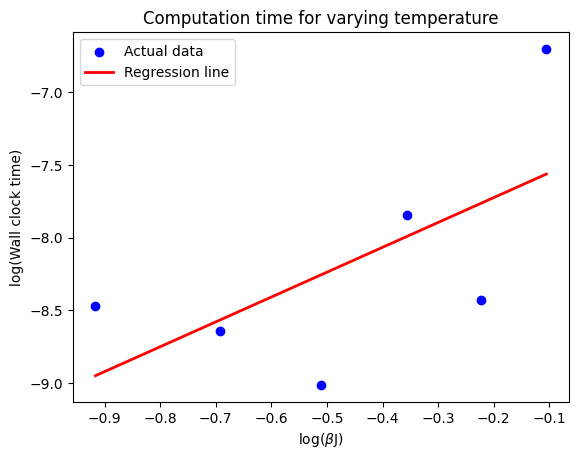

In [96]:
'''Code is contained in regression.py but the data is shown explicitly here.'''

x = np.log([0.4,0.5,0.6,0.7,0.8,0.9])
y = [-8.47045307,-8.64150729,-9.01443517,-7.84179891,-8.4285668,-6.70205889]
y_regression = [-8.950978550772692,-8.569136610414308,-8.257149028405559,-7.993367286355922,-7.76486914801309,-7.5633195060384235]

plt.scatter(x, y, color='blue', label='Actual data')
plt.plot(x, y_regression, color='red', linewidth=2, label='Regression line')
plt.title("Computation time for varying temperature")
plt.xlabel(r"log($\beta$J)")
plt.ylabel("log(Wall clock time)")
plt.legend()
plt.show()

## 4 - Conclusion

In this report, cluster algorithms for statistical models are investigated. The Ising model is explored in detail, and the problem of hard disks is discussed theoretically. Two cluster algorithms are presented, implemented, and compared with the Metropolis algorithm. These are the Wolff algorithm and the Swendsen-Wang algorithm.

The analysis focused on the autocorrelation time of the system but equilibration time and complexity were included too. Implementation of the algorithms showed that the cluster algorithms reached a stationary distribution much faster than the simple Metropolis algorithm. This was reflected in the number of iterations required for the magnetisation to plateau. Forming the clusters reduced the number by a factor of five, from 10000 to 2000.

With satisfactory equilibration, the autocorrelation functions and subsequent autocorrelation times were calculated. This was repeated for a varied lattice size but at a fixed temperature. The approach allowed for the dynamic exponents to be estimated for each algorithm. Dynamic exponents depend on proximity to the critical temperature, hence the temperature was fixed close to the critical point. The cluster algorithms showed a good agreement to expected values: 0.42 (Wolff) and 0.23 (Swendsen-Wang) compared to an expected range of 0.19-0.5. Although the cluster algorithms performed well, the Metropolis-Hasting algorithm did not; 0.19 instead of the expected 1.7-2.2. Comparison between the written code and a different code (only Metropolis-Hasting algorithm) sourced elsewhere indicated that the written code was not allowed sufficient time to equilibrate. Efficiencies in the way the written code was constructed meant that further analysis was carried out using the sourced code. A dynamic exponent was calculated for the sourced code and a value of 1.55 $\pm$ 0.20 was estimated. Though not within the expected range, it is significantly closer than the written code.

The sourced code was then used to produce plots of the magnetisation and internal energy for a varied temperature. Peaks were observed around the critical temperature, as expected. Varying the lattice size had no visible effect on the magnetisation but larger lattices raised the peak height for the internal energy. For both, the data was averaged over the different lattice sizes and a Gaussian was fitted. This gave an estimate of the temperature of the peak. Estimates were close to the actual value (0.44) with values of 0.41 for magnetisation and 0.44 for internal energy.

Lastly, the complexity of the algorithms was examined. For the experiments, the sourced code was not used for the Metropolis-Hastings algorithm; all algorithms were the original written codes. Time complexities were estimated by measuring the wall clock time for the first single iteration fixing lattice size and temperature separately. Fixing the lattice size, resulted in a constant order for the Metropolis-Hastings algorithm but the cluster algorithms showed a peak starting from the critical temperature. This is characteristic of the cluster size growing from the critical temperature. The peak for the Wolff algorithm was significantly larger than for the Swendsen-Wang algorithm. A power law dependence was calculated to be 1.71 for the peak, close to an expected 2. With additional time, an investigation into the cluster size, especially around the critical point, should provide interesting results. Varying temperature only affected the Swendsen-Wang algorithm with a quadratic power measured.

Overall, it can be concluded that cluster algorithms performed better than the Metropolis-Hastings algorithm. This is confirmed by the lower dynamic exponents and the ability to reduce the amount of critical slowing down. Between the Wolff algorithm and the Swendsen-Wang algorithm, the best algorithm is dependent on the case. The Wolff algorithm performs better at larger lattice sizes but not around critical points. This is due to the multiple clusters disrupting critical slowing down better than the single cluster. However, multiple clusters required more time to complete an iteration.

Looking forward, an investigation into thinning, batching, and jackknife resampling should show that the autocorrelation time can be further reduced. Thereby, increasing the performance of the algorithms. Alternatively, a comparison between the Metropolis-Hastings algorithm with cluster algorithms for the hard disk problem would be interesting.

## References

[1] N. Metropolis, A. Rosenbluth, M. Rosenbluth, and A. Teller, Equation of State Calculations by Fast Computing Machines, The Journal of Chemical Physics, 21, 6 (1953), https://www.aliquote.org/pub/metropolis-et-al-1953.pdf<br>
[2] K. Eriksson, Perron-Frobenius' Theory and Applications, Digitala Vetenskapliga Arkivet (2023), LiTH-MAT-EX–2023/05–SE<br>
[3] J. Dahlin, and T. Schön, Getting Started with Particle Metropolis-Hastings for Inference in Nonlinear Dynamical Models, Journal of Statistical Software, 88, 2 (2019), 10.18637/jss.v088.c02<br>
[4] A. Hosseinabadi, F. Alavipour, S. Band, and V. Balas, A Novel Meta-Heuristic Combinatory Method for Solving Capacitated Vehicle Location-Routing Problem with Hard Time Windows, 454 (2016), 10.1007/978-3-319-38789-5_77<br>
[5] A. Blum, C. Dan, S. Seddighin, Learning Complexity of Simulated Annealing, arXiv (2020), 2003.02981<br>
[6] R. Swendsen, and J.-S. Wang, Nonuniversal critical dynamics in Monte Carlo simulations. Phys. Rev. Lett. 58(2), pp. 86–88 (1987), 10.1103/PhysRevLett.58.86<br>
[7] U. Wolff, Collective Monte Carlo updating for spin systems. Phys. Rev. Lett. 62(4), pp. 361–364 (1989), 10.1103/PhysRevLett.62.361<br>
[8] C. Dress, and W. Krauth, Cluster algorithm for hard spheres and related systems. J. Phys. A 28, pp. L597–L601 (1995)<br>
[9] E. Luijten, Introduction to Cluster Monte Carlo Algorithms, Lect. Notes Phys, 703, 13–38 (2006), 10.1007/3-540-35273-2_1<br>
[10] A. Ferrenberg, D. Landau, and Y. Wong, Monte Carlo simulations: Hidden errors from ‘‘good’’ random number generators, Phys. Rev. Lett. 69, 3382 (1992), 10.1103/PhysRevLett.69.3382<br>
[11] F. Wende, and T. Steinke, Swendsen-Wang multi-cluster algorithm for the 2D/3D Ising model on Xeon Phi and GPU, Association for Computing Machinery, 83 (2013), 10.1145/2503210.2503254<br>
[12] E. Kyimba, Comparison of Monte Carlo Metropolis, Swendsen-Wang, and Wolff Algorithms in the Critical Region for the 2-Dimensional Ising
Model, Theses (2006)<br>
[13] T. Budd, NWI-NM042B Monte Carlo Techniques, Radboud University, (Accessed 2025), https://hef.ru.nl/~tbudd/mct/intro.html#about-this-book<br>

## Appendix

### Boltzmann factor:

Consider the sample mean:

$$\overline{X}_{n} = \frac{1}{n} \sum_{i=1}^{n}X_{i}$$

This is an unbiased estimator of $\mathbb{E}[X]$, hence $\mathbb{E}[\overline{X}_{n}] = \mathbb{E}[X]$.

The weak law of large numbers states that the sample mean approaches $\mathbb{E}[X]$. This can be written mathematically as:

$$\mathbb{P}(|\overline{X}_{n} - \mathbb{E}[X]| > \epsilon) \le \frac{\sigma_{X}^{2}}{n \epsilon^{2}} \;\;\;\; \text{for } \epsilon > 0, \text{n} \ge 1$$

The Central limit theorem provides a tighter bound.

$$\mathbb{P}(|\overline{X}_{n} - \mathbb{E}[X]| > \frac{\sigma_{X}}{\sqrt{n}} \epsilon) \;\;\;\; n \rightarrow \infty \;\;\;\; \mathbb{P}(|\mathcal{N}| > \epsilon) = \frac{2}{\sqrt{2\pi}}\int_{\epsilon}^{\infty}e^{-x^{2}/2}dx$$

Therefore, there is a 68% probability that the result lies within $\pm \frac{\sigma_{X}}{\sqrt{n}}$. The uncertainty is dictated by the variance. This is significant for systems governed by a Boltzmann factor. For direct sampling of the 2D Ising model:

$$\mathbb{E}[|M(s)|] = 2^{2^{N}} \mathbb{E}[|M(s')|p(s')]$$

hence as,

$$\sigma_{M}^{2} \approx \mathbb{E}[|M(s)^{2}|] - (\mathbb{E}[|M(s)|])^{2}$$

and $p(s')$ varies between $e^{\pm 2N\beta J}/Z$, the variance is very large.

This derivation assumes statistical independence. Markov chains are not statistically independent, a correlation exists. Large correlations cause the approximation of $\sigma_{X}^{2}$ to become less accurate. This is the motivation for decorrelation of the samples.

### Hardware and time considerations

All code was run on a MacBook Air with an Apple M1 chip. 8 cores (4 for performance and 4 for efficiency) were avaliable along with 8GB of memory. Most simulations took less than 1 minute to run. Simulations where many data points were collected took up to 8 minutes. Usually code was written and left to execute overnight.